# Application of the new Approach on the BPIC 2015 Dataset
*Author: Lennart Ebert (mail@lennart-ebert.de)*
</br></br>

The developed drift explanation appriach is applied on the BPIC 2015 dataset. The BPIC 2015 dataset is the process of EU direct payments for German farmers.

## Setup
### Imports

In [1]:
# imports
import helper
import math
import pm4py
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt


from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog
from pm4py.write import write_xes

from processdrift.explanation import drift_detection
from processdrift.explanation import drift_explanation
from processdrift.explanation import feature_extraction
from processdrift.explanation import population_comparison
from processdrift.explanation import windowing
from processdrift.explanation import change_point_extraction

### Data settings and event log loading

In [2]:
# specify the file paths for each municipal's log
file_path = 'data/real/bpic_2018/BPI Challenge 2018.xes'

In [3]:
# load the event logs
event_log = xes_importer.apply(file_path)

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 43809/43809 [05:37<00:00, 129.63it/s]


## Present basic analysis

In [4]:
def get_basic_stats(event_log, get_attribute_values=False):
    # get some basic statistics (number of events, number of traces, attributes...)
    basic_stats = {}

    # event statistics
    event_stream = pm4py.convert.convert_to_event_stream(event_log)
    number_events = len(event_stream)
    basic_stats['Number of events'] = number_events

    event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)

    if get_attribute_values:
        basic_stats['Event attributes'] = str(sorted(event_attributes))

    number_event_attributes = len(event_attributes)
    basic_stats['Number event attributes'] = number_event_attributes

    # trace statistics
    number_traces = len(event_log)
    basic_stats['Number traces'] = number_traces

    trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
    if get_attribute_values:
        basic_stats['Trace attributes'] = str(sorted(trace_attributes))

    number_trace_attributes = len(trace_attributes)
    basic_stats['Number trace attributes'] = number_trace_attributes

    basic_stats_series = pd.Series(basic_stats)
    return basic_stats_series

In [5]:
basic_stats_series = get_basic_stats(event_log)
basic_stats_series

Number of events           2514266
Number event attributes         12
Number traces                43809
Number trace attributes         61
dtype: int64

In [6]:
# check if all logs have the same event and trace attributes
event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)
trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
print(f'Event Attributes: {event_attributes}')
print(f'Trace Attributes: {trace_attributes}')

Event Attributes: {'success', 'identity:id', 'activity', 'org:resource', 'eventid', 'docid', 'note', 'time:timestamp', 'doctype', 'subprocess', 'docid_uuid', 'concept:name'}
Trace Attributes: {'identity:id', 'penalty_C16', 'penalty_B5', 'penalty_JLP6', 'penalty_C4', 'young farmer', 'applicant', 'penalty_B6', 'cross_compliance', 'penalty_JLP3', 'selected_risk', 'small farmer', 'selected_random', 'application', 'year', 'penalty_AVJLP', 'penalty_AVGP', 'payment_actual2', 'penalty_AVUVP', 'penalty_B16', 'penalty_amount1', 'penalty_JLP5', 'risk_factor', 'penalty_ABP', 'basic payment', 'penalty_amount3', 'payment_actual1', 'penalty_AUVP', 'penalty_JLP2', 'penalty_CC', 'penalty_B2', 'department', 'penalty_AVBP', 'penalty_AJLP', 'area', 'selected_manually', 'rejected', 'penalty_C9', 'penalty_amount0', 'payment_actual3', 'penalty_AGP', 'penalty_B5F', 'amount_applied2', 'penalty_GP1', 'amount_applied1', 'penalty_JLP7', 'penalty_amount2', 'redistribution', 'penalty_B4', 'greening', 'penalty_JLP1'

In [7]:
display(helper.get_examples_of_event_attributes(event_log, 10, event_attributes))

,success,org:resource,docid_uuid,doctype,subprocess,docid,activity,note,eventid,identity:id,concept:name,time:timestamp
0,True,7d12ba,31783437-F762-4C75-A5A7-7480D025660F,Geo parcel document,Declared,-18008418266785396,finish editing,none,-90065998242771484,7B333FFA-FE62-4EC9-AD89-5B1570BF46AC,finish editing,2017-07-03 14:18:48.064000+02:00
1,True,346f05,955F486F-E42A-494B-852E-E5FE57E36445,Geo parcel document,Declared,-18008425218362120,finish editing,none,-54037205719598492,826FAF03-EB7C-4BF6-82C8-3A0286B6CD5E,finish editing,2017-06-22 10:58:53.202000+02:00
2,True,d4758f,525B9D46-87F0-42E8-80A3-AB1E6919338C,Geo parcel document,Main,-18008418256663108,save,none,-144109140353652017,7AE0F646-8A07-40F1-BD67-2A13C7A195C0,save,2017-11-29 13:20:28.136000+01:00
3,True,5a21a5,C7E4BE9E-9FF9-4383-8FDC-794BCFBD103E,Reference alignment,Main,-108080632047847084,save,none,-90066104691177986,6F151061-9023-465F-8592-A50E31F90D1D,save,2016-08-24 13:27:18+02:00
4,False,Notification automaton,83FCE764-87F8-41F5-80B9-43344063F4ED,Payment application,Application,-54037160734804518,insert document,notification for applicant,-126094734587031609,B5AE7471-B863-4327-B0AD-9236CDFF1C9D,insert document,2017-12-20 09:01:56.792000+01:00
5,True,Document processing automaton,2A8611A8-1EE0-44D2-AB34-CED4CEAC199A,Geo parcel document,Declared,-18008424147427846,create,created,-54037218144082894,604891E1-4B16-4734-AB35-769621890454,create,2017-05-11 06:51:39.285000+02:00
6,True,d0f451,28C275B9-5490-436B-B498-558B6B724762,Geo parcel document,Main,-18008532430690714,insert document,,-72051677752716788,D6842C63-A6BC-488C-BD86-D4606D2CDF4B,insert document,2016-11-14 08:00:13.144000+01:00
7,True,Document processing automaton,392D523A-97D6-4A3A-A158-53FAE500158B,Geo parcel document,Main,-18008425218725402,clear,none,-54037218143927042,9581F7B5-B074-4774-931B-CD7BA563B3BF,clear,2017-05-11 07:20:33.840000+02:00
8,True,Document processing automaton,D30F6077-A99D-449E-A3B9-0BAA09B78FA7,Control summary,Main,-18008661120967265,initialize,none,-18008661120967261,4CF23A0C-4ACF-4CC1-B312-0F7A0793E9E2,initialize,2015-06-15 09:09:52+02:00
9,True,727350,8F410AA2-E7DE-4ADC-B7E8-8D2DF96A7136,Geo parcel document,Reported,-18008418263393928,finish editing,automatic,-36022747118039436,D97B3735-7E64-4881-9AA7-105FEE034064,finish editing,2017-12-05 16:13:15.979000+01:00


Of the event attributes, the fields 'docid_uuid', 'docid', 'eventid' and 'identity:id' are ID fields and not selected.
The field 'concept:name' is the activity name field. This captures control flow perspective behavior and is, therefore, not selected. The same goes for the field 'activity'.
The 'time:timestamp' field is abandoned due to it being the execution time of each event.

In [8]:
selected_event_attributes = ['success', 'org:resource', 'doctype', 'subprocess', 'note']
selected_event_attributes

['success', 'org:resource', 'doctype', 'subprocess', 'note']

5 event attributes where selected.

In [9]:
display(helper.get_examples_of_trace_attributes(event_log, 10, trace_attributes))

,young farmer,selected_random,penalty_AJLP,application,penalty_amount0,program-id,penalty_BGKV,penalty_AUVP,applicant,risk_factor,...,penalty_JLP7,year,penalty_JLP5,penalty_JLP2,penalty_JLP3,number_parcels,penalty_JLP1,penalty_amount1,payment_actual1,amount_applied1
0,True,False,False,1bd86db8b30a6cfb,0.00,215,False,False,333299df7786ad37,1.0,...,False,2017,False,False,False,14,False,NaN,NaN,NaN
1,False,False,False,01474ada3a39c97a,0.00,215,False,False,1414648c1f6ad2b5,1.0,...,False,2016,False,False,False,2,False,NaN,NaN,NaN
2,False,False,False,a04327c0608feb92,0.00,215,False,False,344a60200d31c2f1,1.0,...,False,2017,False,False,False,4,False,NaN,NaN,NaN
3,False,False,False,c172acc955d9c519,0.00,215,False,False,a64c5090220e5f0a,1.0,...,False,2016,False,False,False,23,False,NaN,NaN,NaN
4,True,False,False,0c51e33ca826a6e2,0.00,215,False,False,b47d982134b5f97a,1.0,...,False,2016,False,False,False,11,False,NaN,NaN,NaN
5,False,False,False,973195ea041e8f48,0.00,215,False,False,ae9fd6e624c81e1f,1.0,...,False,2017,False,False,False,2,False,NaN,NaN,NaN
6,False,False,False,3ec30f6930e367f2,61.01,215,False,False,f7d17f6107c5c573,1.0,...,False,2016,False,False,False,32,False,128.31,-100.79,35349.39
7,True,False,False,ec98758ca42e9a46,0.00,215,False,False,e7335edb6952df6a,1.0,...,False,2017,False,False,False,49,False,NaN,NaN,NaN
8,False,False,False,2b1e5614348c37e1,30.70,215,False,False,d18bc2d885a4069a,1.0,...,False,2015,False,False,False,29,False,NaN,NaN,NaN
9,False,False,False,cf09ecaff602fd35,35.27,215,False,False,7fb8360705adcd39,1.0,...,False,2015,False,False,False,10,False,NaN,NaN,NaN


On trace level there are 61 attribute fields. Filtering these through manual review would be too time expensive. Therefore, the following strategy is deployed:
1. If multiple fields are highly correlated, only select one of them
2. Do not select fields that are highly variable. These are most probably (quasi) unique identifiers with little value in the analysis due to them always changing significantly.

This analysis is performed on a sub-sample of 10000 traces.

In [10]:
sub_sample_df = helper.get_examples_of_trace_attributes(event_log, 10000, trace_attributes)

In [11]:
# replace all boolean with integer values
sub_sample_df.replace({False: 0, True: 1}, inplace=True)
sub_sample_df

numeric_columns = sub_sample_df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = list(set(sub_sample_df.columns) - set(numeric_columns))

print(f'{len(numeric_columns)} numeric columns and {len(categorical_columns)} categorical columns.')
print(f'Categorical columns: {categorical_columns}')

55 numeric columns and 6 categorical columns.
Categorical columns: ['identity:id', 'department', 'applicant', 'program-id', 'application', 'year']


1. 'year' was incorrectly detected as categorical attribute. It is deleted from the columns because, like timestamps, it will have no value for explaining process change.
2. To reduce the number of numerical columns, highly correlated columns are deleted from the analysis.

In [12]:
categorical_columns.remove('year')
categorical_columns.remove('identity:id')
categorical_columns.remove('application')

categorical_columns

['department', 'applicant', 'program-id']

In [13]:
display(helper.get_examples_of_trace_attributes(event_log, 100, trace_attributes)[categorical_columns])

,department,applicant,program-id
0,4e,aa026d48d1cb848b,215
1,4e,a29686461f16a899,215
2,6b,32c67a1d3b3255d1,215
3,4e,16bc3a7ff72fdab3,215
4,d4,22317b37bf6f231b,215
...,...,...,...
95,6b,ae57be869800434a,215
96,6b,7cb1d71a734a28d2,215
97,4e,3088a68ed4949215,215
98,e7,4f0e8280778ac697,215


In [14]:
categorical_columns.remove('program-id')
categorical_columns

['department', 'applicant']

Perform correlation analysis for numerical and boolean attributes.

In [15]:
def get_correlated_columns(correlation_df, correlation_threshold):
    # get all correlated attributes for each attribute
    correlated_dict = {}
    for row_name, row in correlation_df.iterrows():
        for column_name, corr_value in row.items():
            if abs(corr_value) > correlation_threshold:
                # don't record correlation if column and row are identifcal
                if column_name != row_name:
                    if row_name in correlated_dict:
                        correlated_dict[row_name].append(column_name)
                    else:
                        correlated_dict[row_name] = [column_name]
    return correlated_dict

In [16]:
# Determine correlation for numeric columns

# Start by determining the correlation of numeric and boolean fields
numeric_correlations_df = sub_sample_df[numeric_columns].corr()
display(numeric_correlations_df)
# get all attribute pairs with correlations > 0.95
correlation_threshold = 0.95

,young farmer,selected_random,penalty_AJLP,penalty_amount0,penalty_BGKV,penalty_AUVP,risk_factor,small farmer,penalty_BGP,penalty_C16,...,penalty_JLP1,penalty_amount1,payment_actual1,amount_applied1,penalty_amount2,payment_actual2,amount_applied2,penalty_amount3,payment_actual3,amount_applied3
young farmer,1.000000,0.001913,0.137538,0.077708,-0.006510,0.003169,0.002911,-0.039498,-0.009794,-0.004117,...,0.178766,0.064322,0.026619,-0.054054,0.200552,-0.508413,-0.075416,NaN,NaN,NaN
selected_random,0.001913,1.000000,-0.010105,0.009638,0.032055,0.001911,0.002524,-0.001708,0.065310,-0.003570,...,-0.005013,-0.039158,0.021676,-0.023283,-0.075739,0.038128,-0.101868,NaN,NaN,NaN
penalty_AJLP,0.137538,-0.010105,1.000000,0.094488,-0.000895,0.232672,0.000400,-0.008840,-0.003962,-0.000566,...,-0.002083,0.057533,0.168452,-0.001855,NaN,NaN,NaN,NaN,NaN,NaN
penalty_amount0,0.077708,0.009638,0.094488,1.000000,0.018185,0.093822,-0.001288,-0.036876,0.083053,0.002464,...,0.190688,0.759969,0.384689,0.138373,0.832610,-0.094682,0.133382,NaN,NaN,NaN
penalty_BGKV,-0.006510,0.032055,-0.000895,0.018185,1.000000,-0.003113,0.000224,-0.004939,-0.002214,-0.000316,...,-0.001164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
penalty_AUVP,0.003169,0.001911,0.232672,0.093822,-0.003113,1.000000,0.001392,0.007531,0.008647,-0.001968,...,0.006874,0.039397,0.088684,-0.053495,0.008381,-0.055602,-0.090841,NaN,NaN,NaN
risk_factor,0.002911,0.002524,0.000400,-0.001288,0.000224,0.001392,1.000000,0.002208,0.000990,0.000141,...,0.000520,0.008667,-0.010931,0.002886,NaN,NaN,NaN,NaN,NaN,NaN
small farmer,-0.039498,-0.001708,-0.008840,-0.036876,-0.004939,0.007531,0.002208,1.000000,-0.021856,-0.003123,...,-0.011490,-0.041110,0.032577,-0.062970,NaN,NaN,NaN,NaN,NaN,NaN
penalty_BGP,-0.009794,0.065310,-0.003962,0.083053,-0.002214,0.008647,0.000990,-0.021856,1.000000,0.070754,...,-0.005150,-0.004257,0.006359,0.054112,NaN,NaN,NaN,NaN,NaN,NaN
penalty_C16,-0.004117,-0.003570,-0.000566,0.002464,-0.000316,-0.001968,0.000141,-0.003123,0.070754,1.000000,...,-0.000736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
numeric_correlations_df = sub_sample_df[numeric_columns].corr()
correlated_columns = get_correlated_columns(numeric_correlations_df, 0.95)

correlation_final = pd.Series({corr_from: ", ".join(corr_to_list) for corr_from, corr_to_list in correlated_columns.items()})
display(correlation_final)

# export change points to latex
path = 'results/latex/bpic_2018_correlations.tex'
with open(path, 'w') as file:
    correlation_final.to_latex(file, float_format="%.2f")

penalty_ABP                                              penalty_AGP
penalty_AGP                                              penalty_ABP
payment_actual0    amount_applied0, amount_applied1, amount_applied2
amount_applied0    payment_actual0, amount_applied1, amount_applied2
amount_applied1    payment_actual0, amount_applied0, amount_applied2
amount_applied2    payment_actual0, amount_applied0, amount_applied1
dtype: object

C:\Users\Lennart\AppData\Local\Temp\ipykernel_22160\346594395.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  correlation_final.to_latex(file, float_format="%.2f")


In [18]:
# manually select which trace attributes to remove
numeric_columns.remove('penalty_AGP')
numeric_columns.remove('amount_applied0')
numeric_columns.remove('amount_applied1')
numeric_columns.remove('amount_applied2')
numeric_columns.remove('penalty_amount2')
print(len(numeric_columns))

50


In [20]:
selected_trace_attributes = numeric_columns + categorical_columns
selected_trace_attributes

['young farmer',
 'selected_random',
 'penalty_AJLP',
 'penalty_amount0',
 'penalty_BGKV',
 'penalty_AUVP',
 'risk_factor',
 'small farmer',
 'penalty_BGP',
 'penalty_C16',
 'penalty_BGK',
 'penalty_AVUVP',
 'penalty_CC',
 'penalty_AVJLP',
 'penalty_C9',
 'cross_compliance',
 'rejected',
 'greening',
 'penalty_C4',
 'penalty_AVGP',
 'penalty_ABP',
 'penalty_B6',
 'penalty_B4',
 'penalty_B5',
 'penalty_AVBP',
 'penalty_B2',
 'selected_risk',
 'penalty_B3',
 'area',
 'selected_manually',
 'penalty_B16',
 'penalty_GP1',
 'basic payment',
 'penalty_B5F',
 'penalty_V5',
 'payment_actual0',
 'redistribution',
 'penalty_JLP6',
 'penalty_JLP7',
 'penalty_JLP5',
 'penalty_JLP2',
 'penalty_JLP3',
 'number_parcels',
 'penalty_JLP1',
 'penalty_amount1',
 'payment_actual1',
 'payment_actual2',
 'penalty_amount3',
 'payment_actual3',
 'amount_applied3',
 'department',
 'applicant']

In [21]:
attribute_level_type_list = helper.automatically_get_attributes_and_data_types(event_log, selected_trace_attributes, selected_event_attributes)
attribute_level_type_list

[('young farmer', 'trace', 'continuous'),
 ('selected_random', 'trace', 'continuous'),
 ('penalty_AJLP', 'trace', 'continuous'),
 ('penalty_amount0', 'trace', 'continuous'),
 ('penalty_BGKV', 'trace', 'continuous'),
 ('penalty_AUVP', 'trace', 'continuous'),
 ('applicant', 'trace', 'categorical'),
 ('risk_factor', 'trace', 'continuous'),
 ('small farmer', 'trace', 'continuous'),
 ('penalty_BGP', 'trace', 'continuous'),
 ('department', 'trace', 'categorical'),
 ('penalty_C16', 'trace', 'continuous'),
 ('penalty_BGK', 'trace', 'continuous'),
 ('penalty_AVUVP', 'trace', 'continuous'),
 ('penalty_CC', 'trace', 'continuous'),
 ('penalty_AVJLP', 'trace', 'continuous'),
 ('penalty_C9', 'trace', 'continuous'),
 ('cross_compliance', 'trace', 'continuous'),
 ('rejected', 'trace', 'continuous'),
 ('greening', 'trace', 'continuous'),
 ('penalty_C4', 'trace', 'continuous'),
 ('penalty_AVGP', 'trace', 'continuous'),
 ('penalty_ABP', 'trace', 'continuous'),
 ('penalty_B6', 'trace', 'continuous'),
 ('p

### Configure Primary Drift Detector

In [17]:
# alternative 1: ProDrift Drift detector
primary_window_size = 200
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=primary_window_size,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [ ]:
primary_changes = primary_process_drift_detector.get_changes(event_log)

exporting log, completed traces :: 100%|██████████| 43809/43809 [05:24<00:00, 134.86it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpdn64ki6d\event_log.xes" -ddm runs -ws 200


CalledProcessError: Command 'java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpdn64ki6d\event_log.xes" -ddm runs -ws 200' returned non-zero exit status 1.

ProDrift did not work and it is unclear why. When running ProDrift from the console, the problem becomes obvious:

```
Exception in thread "main" java.lang.OutOfMemoryError: Java heap space
        at org.deckfour.xes.model.impl.XAttributeImpl.clone(XAttributeImpl.java:178)
        at org.deckfour.xes.model.impl.XAttributeLiteralImpl.clone(XAttributeLiteralImpl.java:124)
        at org.deckfour.xes.model.impl.XAttributeMapImpl.clone(XAttributeMapImpl.java:97)
        at org.deckfour.xes.model.impl.XEventImpl.clone(XEventImpl.java:159)
        at org.deckfour.xes.model.impl.XTraceImpl.clone(XTraceImpl.java:127)
        at org.deckfour.xes.model.impl.XLogImpl.clone(XLogImpl.java:155)
        at org.apromore.prodrift.util.XLogManager.orderByTraceCompletionTimeStamp(XLogManager.java:1071)
        at org.apromore.prodrift.main.Main.RunCommandLine(Main.java:269)
        at org.apromore.prodrift.main.Main.main(Main.java:79)
```

Out of Memory.

This can be handled through using an own implementation of a change point detector or through splitting the log into smaller parts.

In [ ]:
primary_window_size = 200
primary_slide_by = 10
primary_feature_extractor = feature_extraction.RunsFE()
primary_window_generator = windowing.FixedWG(window_size=primary_window_size, slide_by=primary_slide_by)
primary_population_comparer = population_comparison.GTestPC(0)

primary_threshold = 0.05
primary_phi = math.ceil(primary_window_size / primary_slide_by * 0.5)
primary_rho = 3
print(f"primary_phi={primary_phi}, primary_rho={primary_rho}")

primary_change_point_extractor = change_point_extraction.PhiFilterCPE(primary_threshold, primary_phi, primary_rho)

primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)

primary_phi=10, primary_rho=3


In [ ]:
primary_changes = primary_process_drift_detector.get_changes(event_log)

<AxesSubplot:>

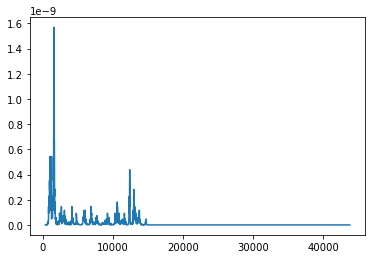

In [ ]:
primary_changes.change_series.plot()

Runs as a features resulted in p-values that are constantly smaller than 0. Another feature is tried for the primary axis.

In [ ]:
primary_feature_extractor = feature_extraction.RelationalEntropyFE()
primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)
primary_changes = primary_process_drift_detector.get_changes(event_log)
primary_changes

Change points: [1029, 19589, 4999, 399, 33679, 37649, 42899, 2199, 7329, 9889, 6819, 10529, 16169, 14379, 13369, 3259, 36159, 21589, 24919, 3429, 9199, 25589, 11769, 35579, 12669]
Has a change series.

<AxesSubplot:>

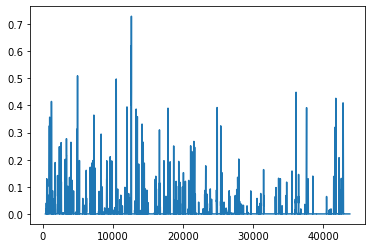

In [ ]:
primary_changes.change_series.plot()

Same problem with the relational entropy feature extractor.

So split the log into sublogs.

In [ ]:
# splitting the log into 4, resulting into logs of sizes [10952, 10952, 10952, 10953]
# starting from the second log, the first 2*window width of the log is overlapping so that all drifts can be captured
# get start and ends of the sub logs
log_sizes = [10952, 10952, 10952, 10953]
log_start_ends = []
end = -1
for i, log_size in enumerate(log_sizes):
    regular_start = end + 1
    start = regular_start
    if i != 0:
        start -= 2 * primary_window_size
    end = regular_start + log_size - 1
    log_start_ends.append((start, end))
log_start_ends

[(0, 10951), (10552, 21903), (21504, 32855), (32456, 43808)]

In [ ]:
for i, (start, end) in enumerate(log_start_ends):
    traces = event_log[start:end]
    sub_log = EventLog(traces, attributes=event_log.attributes, extensions=event_log.extensions, classifiers=event_log.classifiers,
                omni_present=event_log.omni_present, properties=event_log.properties)
    # save the sub log to file
    write_xes(sub_log, f'{file_path}_sub_{i+1}.xes')
    start = end + 1
    # sleep a second to avoid conflicting writes
    time.sleep(1)

In [ ]:
# get the file paths
file_paths = {'part_1': f'{file_path}_sub_1.xes',
                    'part_2':  f'{file_path}_sub_2.xes',
                    'part_3':  f'{file_path}_sub_3.xes',
                    'part_4': f'{file_path}_sub_4.xes',}
parts = list(file_paths.keys())

In [ ]:
# load the sub logs
event_logs = {part: xes_importer.apply(file_path) for part, file_path in file_paths.items()}

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 11352/11352 [01:26<00:00, 130.70it/s]


In [ ]:
# set to the ProDrift Drift detector
primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
                                                                        drift_detection_mechanism='runs',
                                                                        window_size=primary_window_size,
                                                                        window_mode='adaptive',
                                                                        detect_gradual_as_well=False)

In [ ]:
primary_changes_per_part = {}
for part, sub_event_log in event_logs.items():
    # create the change point explainer
    changes = primary_process_drift_detector.get_changes(sub_event_log)
    primary_changes_per_part[part] = changes

exporting log, completed traces :: 100%|██████████| 10951/10951 [01:06<00:00, 164.02it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpdvnlj6pa\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 1770 (Thu Feb 18 07:22:34 CET 2016) after reading 1952 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 4177 (Thu Feb 18 07:50:06 CET 2016) after reading 4218 traces.\r\n\r\n\r\n(3) Sudden drift detected at trace: 5913 (Thu Apr 14 13:23:36 CEST 2016) after reading 7738 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 11351/11351 [01:18<00:00, 144.31it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmp_ziafcn3\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 786 (Thu Feb 18 07:27:56 CET 2016) after reading 990 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 1655 (Thu Feb 18 07:52:51 CET 2016) after reading 1730 traces.\r\n\r\n\r\n(3) Sudden drift detected at trace: 2163 (Wed Mar 30 07:42:27 CEST 2016) after reading 2725 traces.\r\n\r\n\r\n(4) Sudden drift detected at trace: 4751 (Fri Jan 06 13:38:43 CET 2017) after reading 4824 traces.\r\n\r\n\r\n(5) Sudden drift detected at trace: 6461 (Fri Jan 06 14:23:39 CET 2017) after reading 6799 traces.\r\n\r\n\r\n(6) Sudden drift detected at trace: 8716 (Fri Jan 27 06:40:19 CET 2017) after reading 10607 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 11351/11351 [01:12<00:00, 156.05it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmpi1yb8_vl\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 1959 (Fri Jan 06 13:38:47 CET 2017) after reading 2088 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 3894 (Fri Jan 06 14:24:26 CET 2017) after reading 5785 traces.\r\n\r\n\r\n'


exporting log, completed traces :: 100%|██████████| 11352/11352 [01:15<00:00, 150.14it/s]


java -jar "ProDrift2.5/ProDrift2.5.jar" -fp "C:\Users\Lennart\AppData\Local\Temp\tmp55ajejan\event_log.xes" -ddm runs -ws 200
b'event_log.xes\r\nruns\r\nInitial window size = 200\r\nWindow type = ADWIN\r\n*********************************************\r\n\r\n(1) Sudden drift detected at trace: 3098 (Fri Jan 05 15:24:53 CET 2018) after reading 3217 traces.\r\n\r\n\r\n(2) Sudden drift detected at trace: 6550 (Fri Jan 05 16:05:42 CET 2018) after reading 6665 traces.\r\n\r\n\r\n(3) Sudden drift detected at trace: 8096 (Fri Jan 05 16:24:32 CET 2018) after reading 8380 traces.\r\n\r\n\r\n'


In [ ]:
# get the change points (they need to be adjusted by the offset of each part)
primary_change_points = []
for i, (start, end) in enumerate(log_start_ends):
    part = parts[i]
    relative_cps = primary_changes_per_part[part].change_points
    for relative_cp in relative_cps:
        absolute_cp = relative_cp + start
        primary_change_points.append(absolute_cp)
primary_change_points

[1770,
 4177,
 5913,
 11338,
 12207,
 12715,
 15303,
 17013,
 19268,
 23463,
 25398,
 35554,
 39006,
 40552]

Results from ProDrift:

Part 1 (Start: trace 0)

![alt text](results/bpic_2018/pro_drift/part_1.png "Primary Change Series Part 1")

Part 2 (Start: trace 10552)

![alt text](results/bpic_2018/pro_drift/part_2.png "Primary Change Series Part 2")

Part 3 (Start: trace 21504)

![alt text](results/bpic_2018/pro_drift/part_3.png "Primary Change Series Part 3")

Part 4 (Start: trace 32456)

![alt text](results/bpic_2018/pro_drift/part_4.png "Primary Change Series Part 4")

All change points: 
```Python
[1770, 4177, 5913, 11338, 12207, 12715, 15303, 17013, 19268,
 23463, 25398, 35554, 39006, 40552]
```

In [22]:
# get the timestamps of the change points
primary_change_points = [1770, 4177, 5913, 11338, 12207, 12715, 15303, 17013, 19268, 23463, 25398, 35554, 39006, 40552]
primary_change_points_timestamps = []
for change_point in primary_change_points:
    primary_change_points_timestamps.append(event_log[change_point][0]['time:timestamp'])
print('\n'.join([str(ts) for ts in primary_change_points_timestamps]))

2015-05-05 00:00:00+02:00
2015-04-22 00:00:00+02:00
2015-04-27 00:00:00+02:00
2015-04-24 00:00:00+02:00
2015-04-26 00:00:00+02:00
2015-04-15 00:00:00+02:00
2016-04-12 00:00:00+02:00
2016-04-27 00:00:00+02:00
2016-05-06 00:00:00+02:00
2016-04-25 00:00:00+02:00
2016-04-21 00:00:00+02:00
2017-05-12 00:00:00+02:00
2017-05-11 00:00:00+02:00
2017-05-11 00:00:00+02:00


In [23]:
# the secondary drift detector is set to a True Known Drift Detector with the change points that where 
# extracted through ProDrift
primary_process_drift_detector = drift_detection.TrueKnownDD(primary_change_points)

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [24]:
secondary_window_size = 200
secondary_slide_by = 20

max_distance = 300

secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by * 0.5)
secondary_rho = math.ceil(secondary_window_size / secondary_slide_by * 0.01)
secondary_threshold = 0.05

change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_type_list,
                                                                         secondary_window_generator, 
                                                                         change_point_extractor,
                                                                         min_samples_per_test=5)

In [25]:
# get the change point explanations
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)
changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)

In [26]:
# show the change point explanation table
changes.to_table()

,Primary Change Point,Detector,Secondary Change Point,Lag
0,1770,event: doctype,1810,40
1,1770,event: doctype,1470,-300
2,1770,event: subprocess,1470,-300
3,4177,event: doctype,4317,140
4,11338,event: doctype,11458,120
5,11338,event: doctype,11158,-180
6,12207,event: doctype,12227,20
7,12207,event: doctype,11987,-220
8,15303,trace: penalty_B2,15003,-300
9,15303,trace: penalty_amount0,15003,-300


In [27]:
# export change points to latex
path = 'results/latex/bpic_2018_change_points.tex'
with open(path, 'w') as file:
    changes.to_table().to_latex(file, float_format="%.2f", index=False)

C:\Users\Lennart\AppData\Local\Temp\ipykernel_22160\3499447720.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  changes.to_table().to_latex(file, float_format="%.2f", index=False)


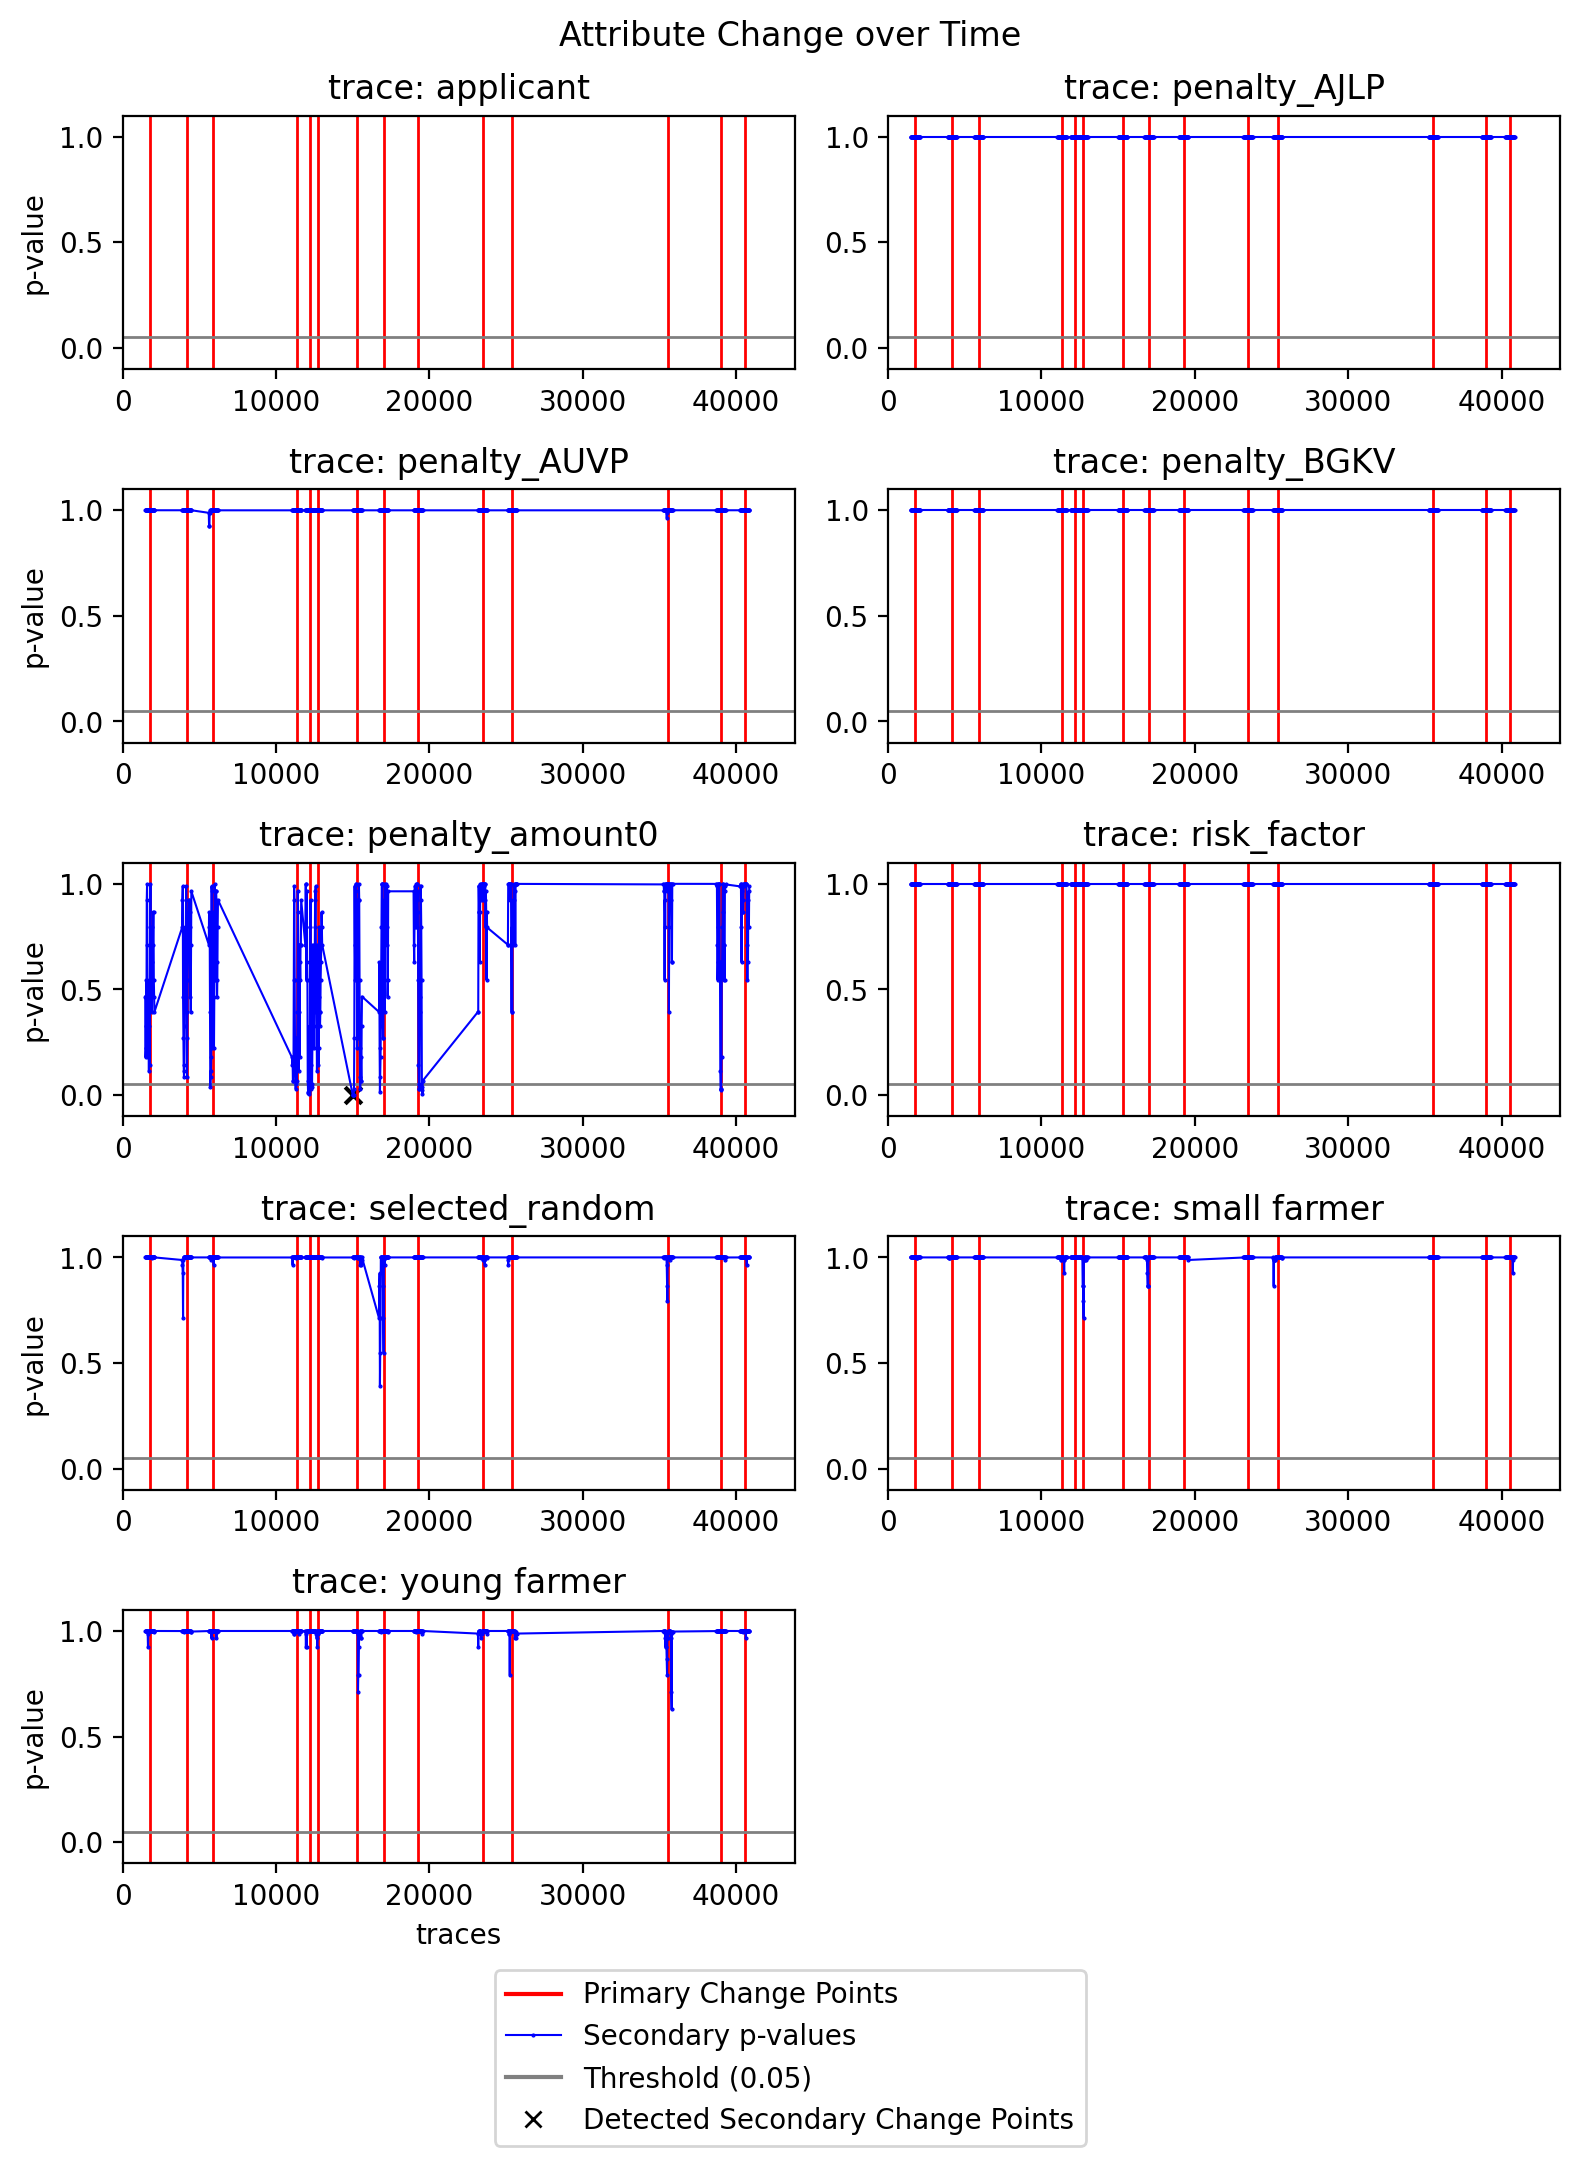

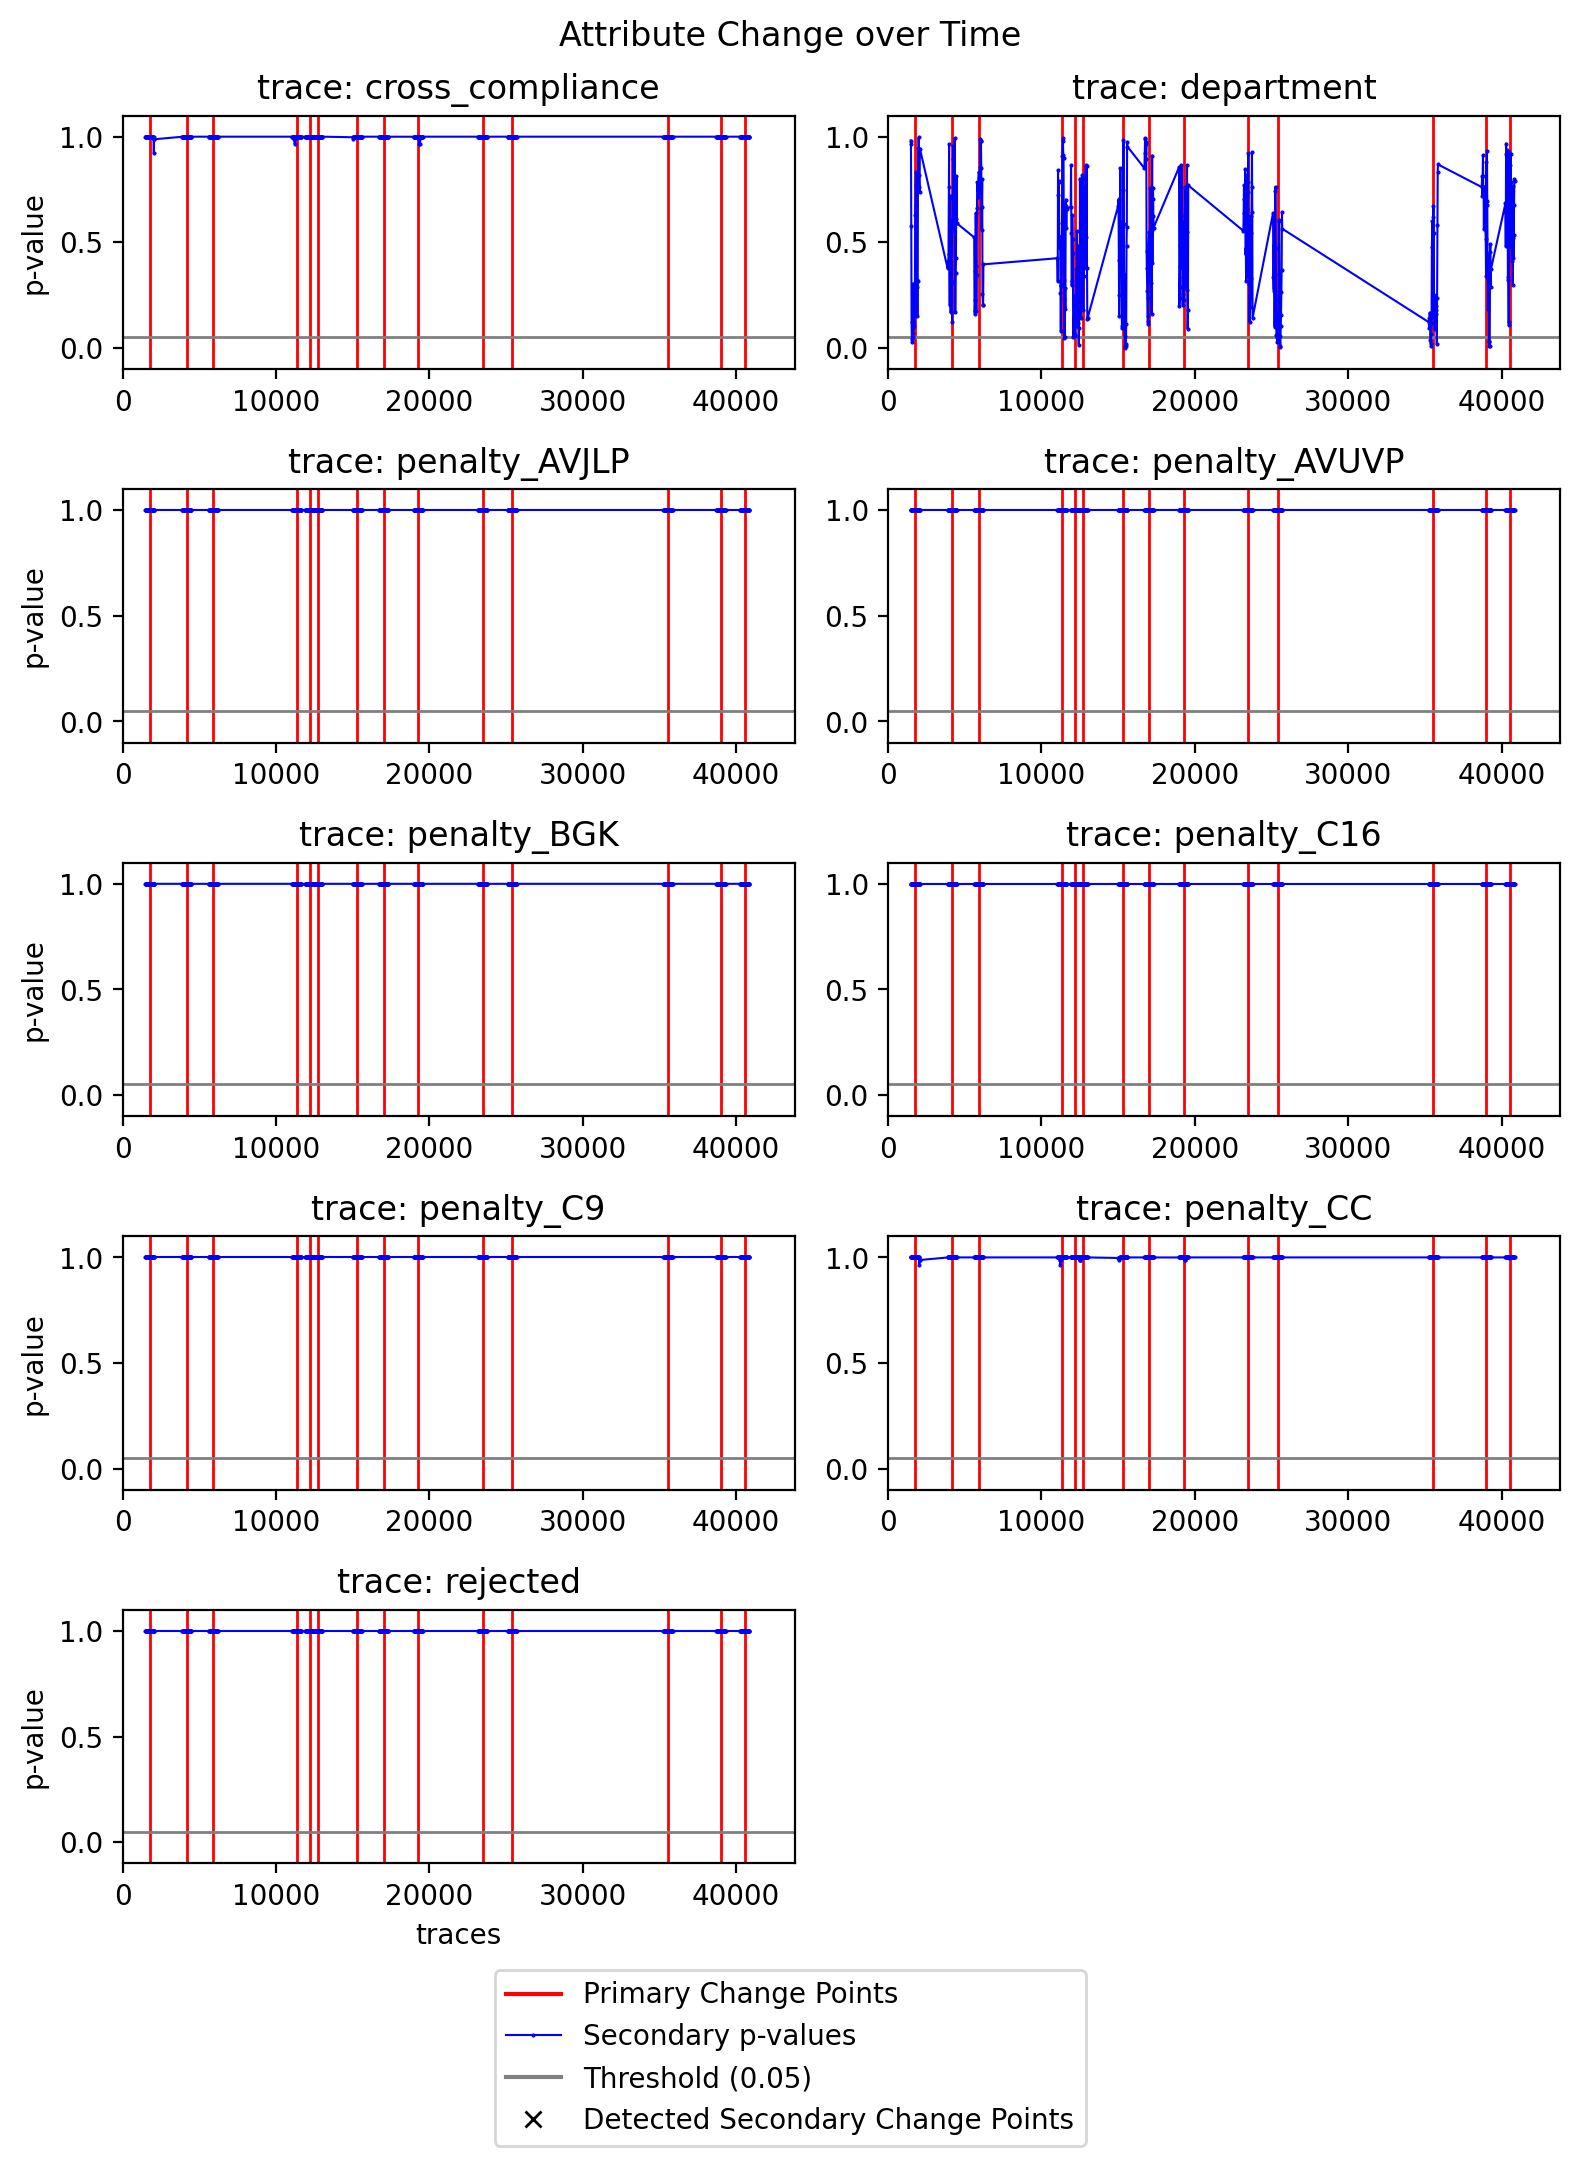

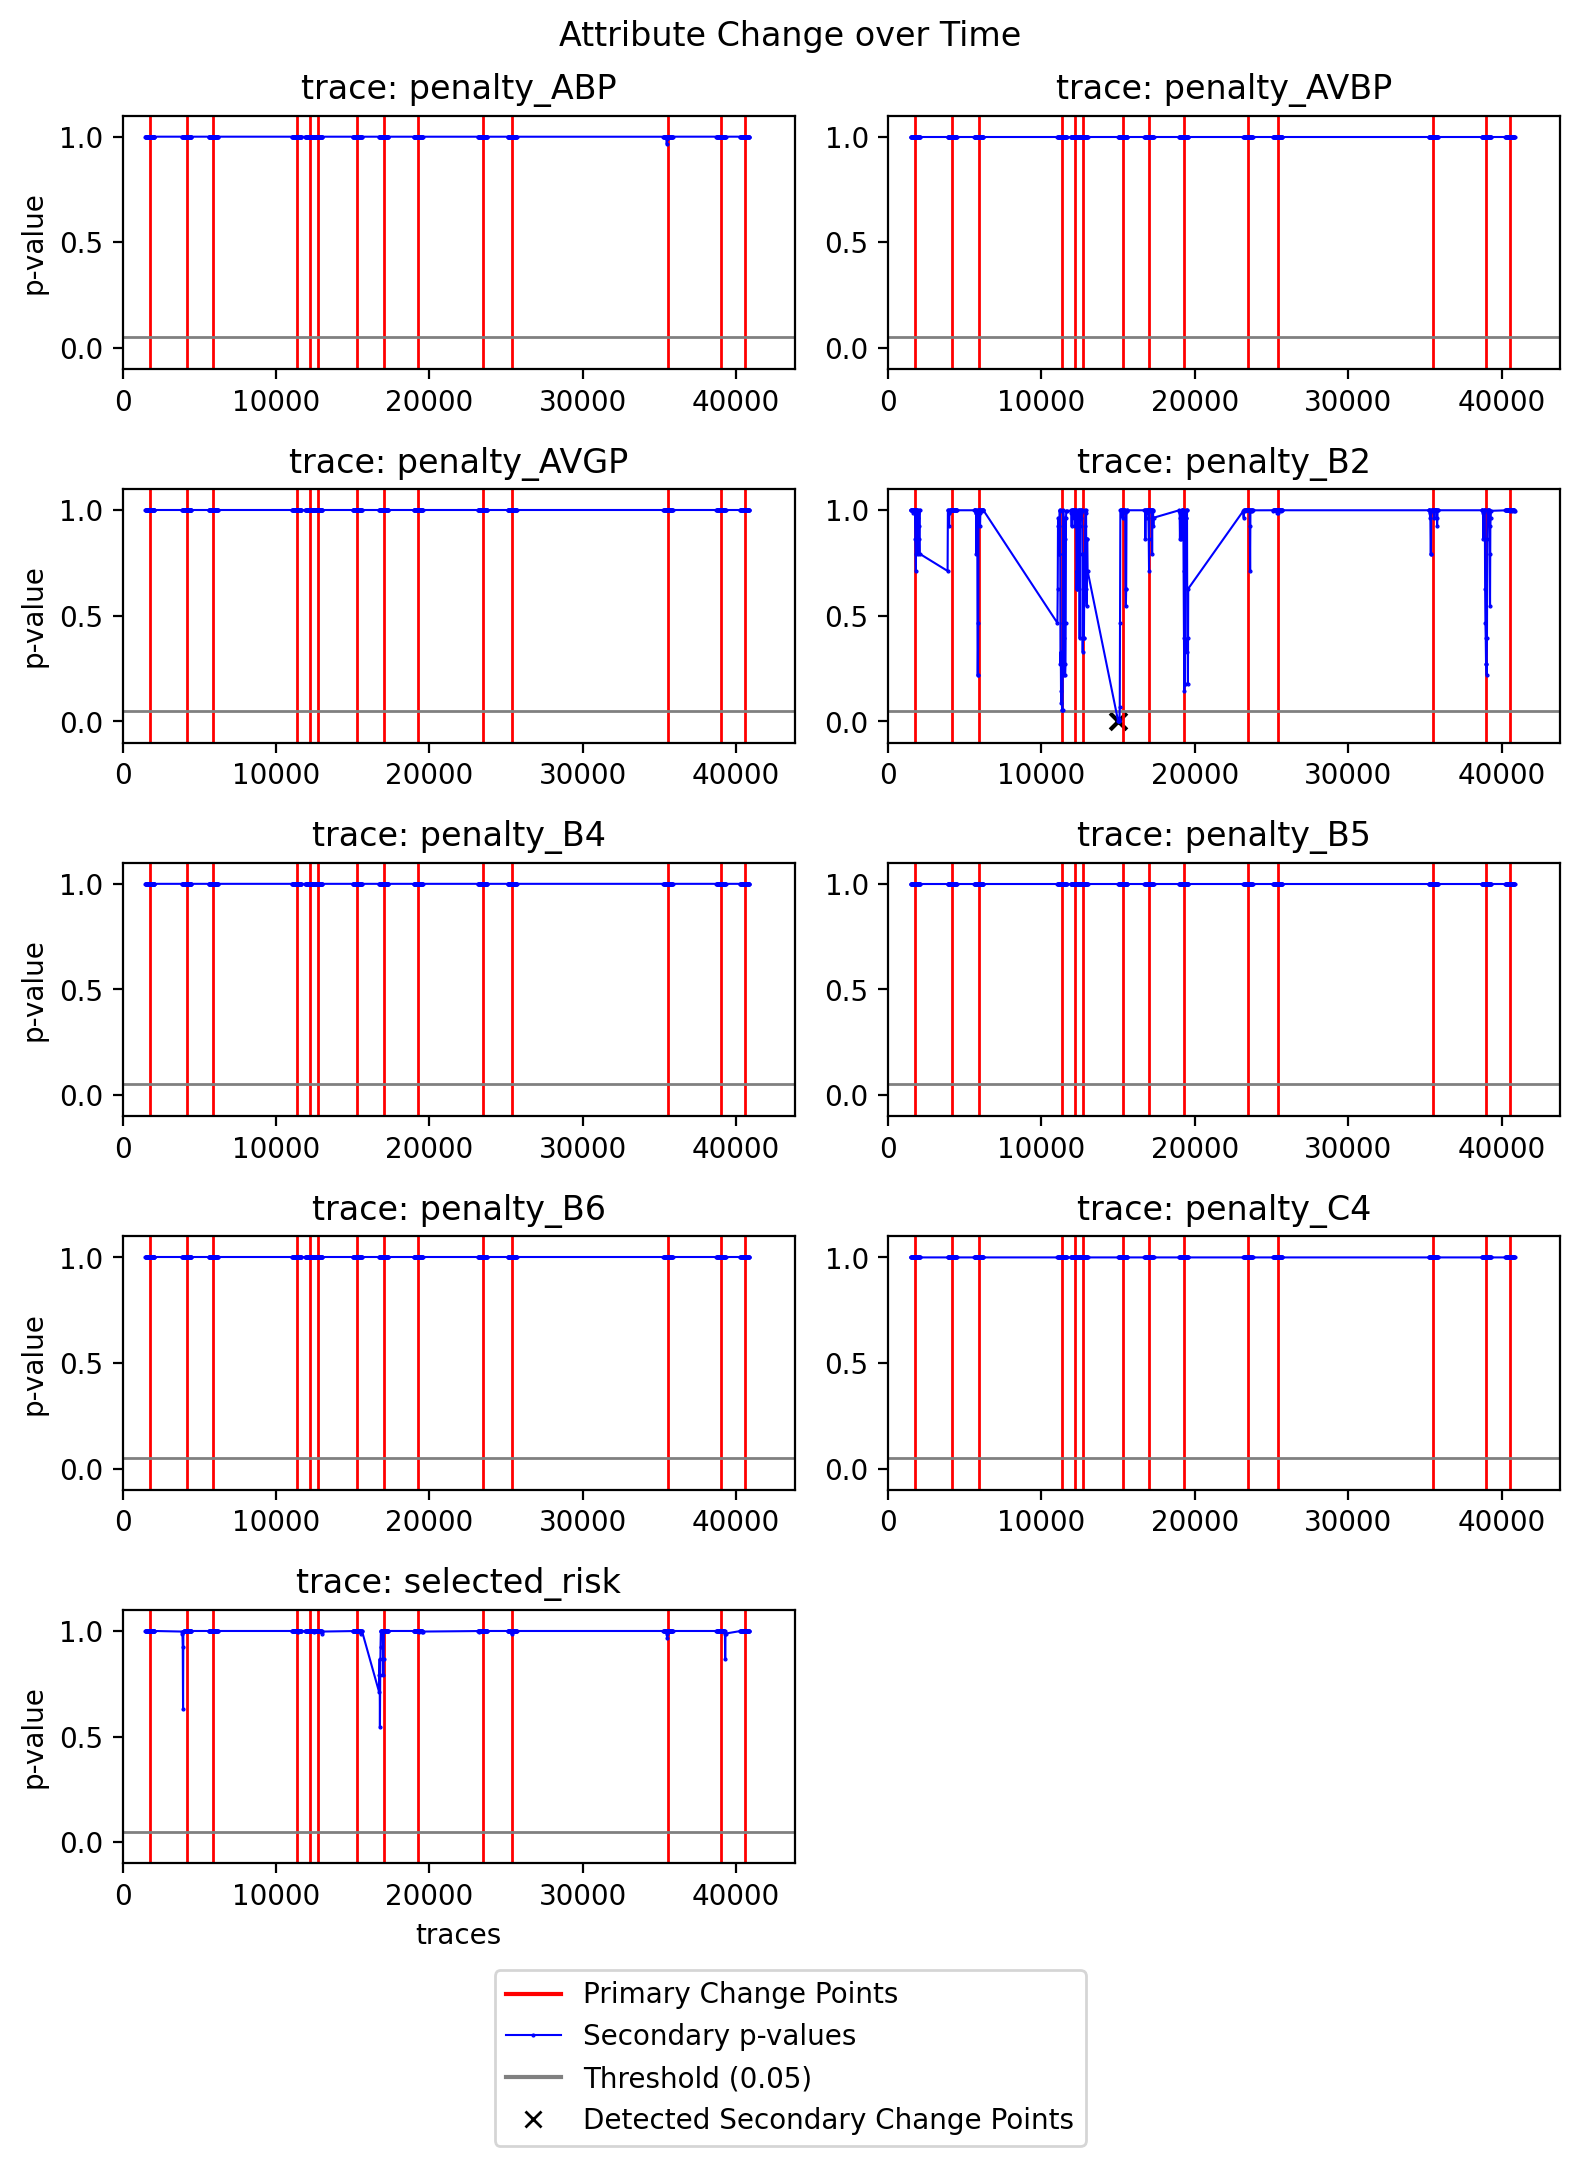

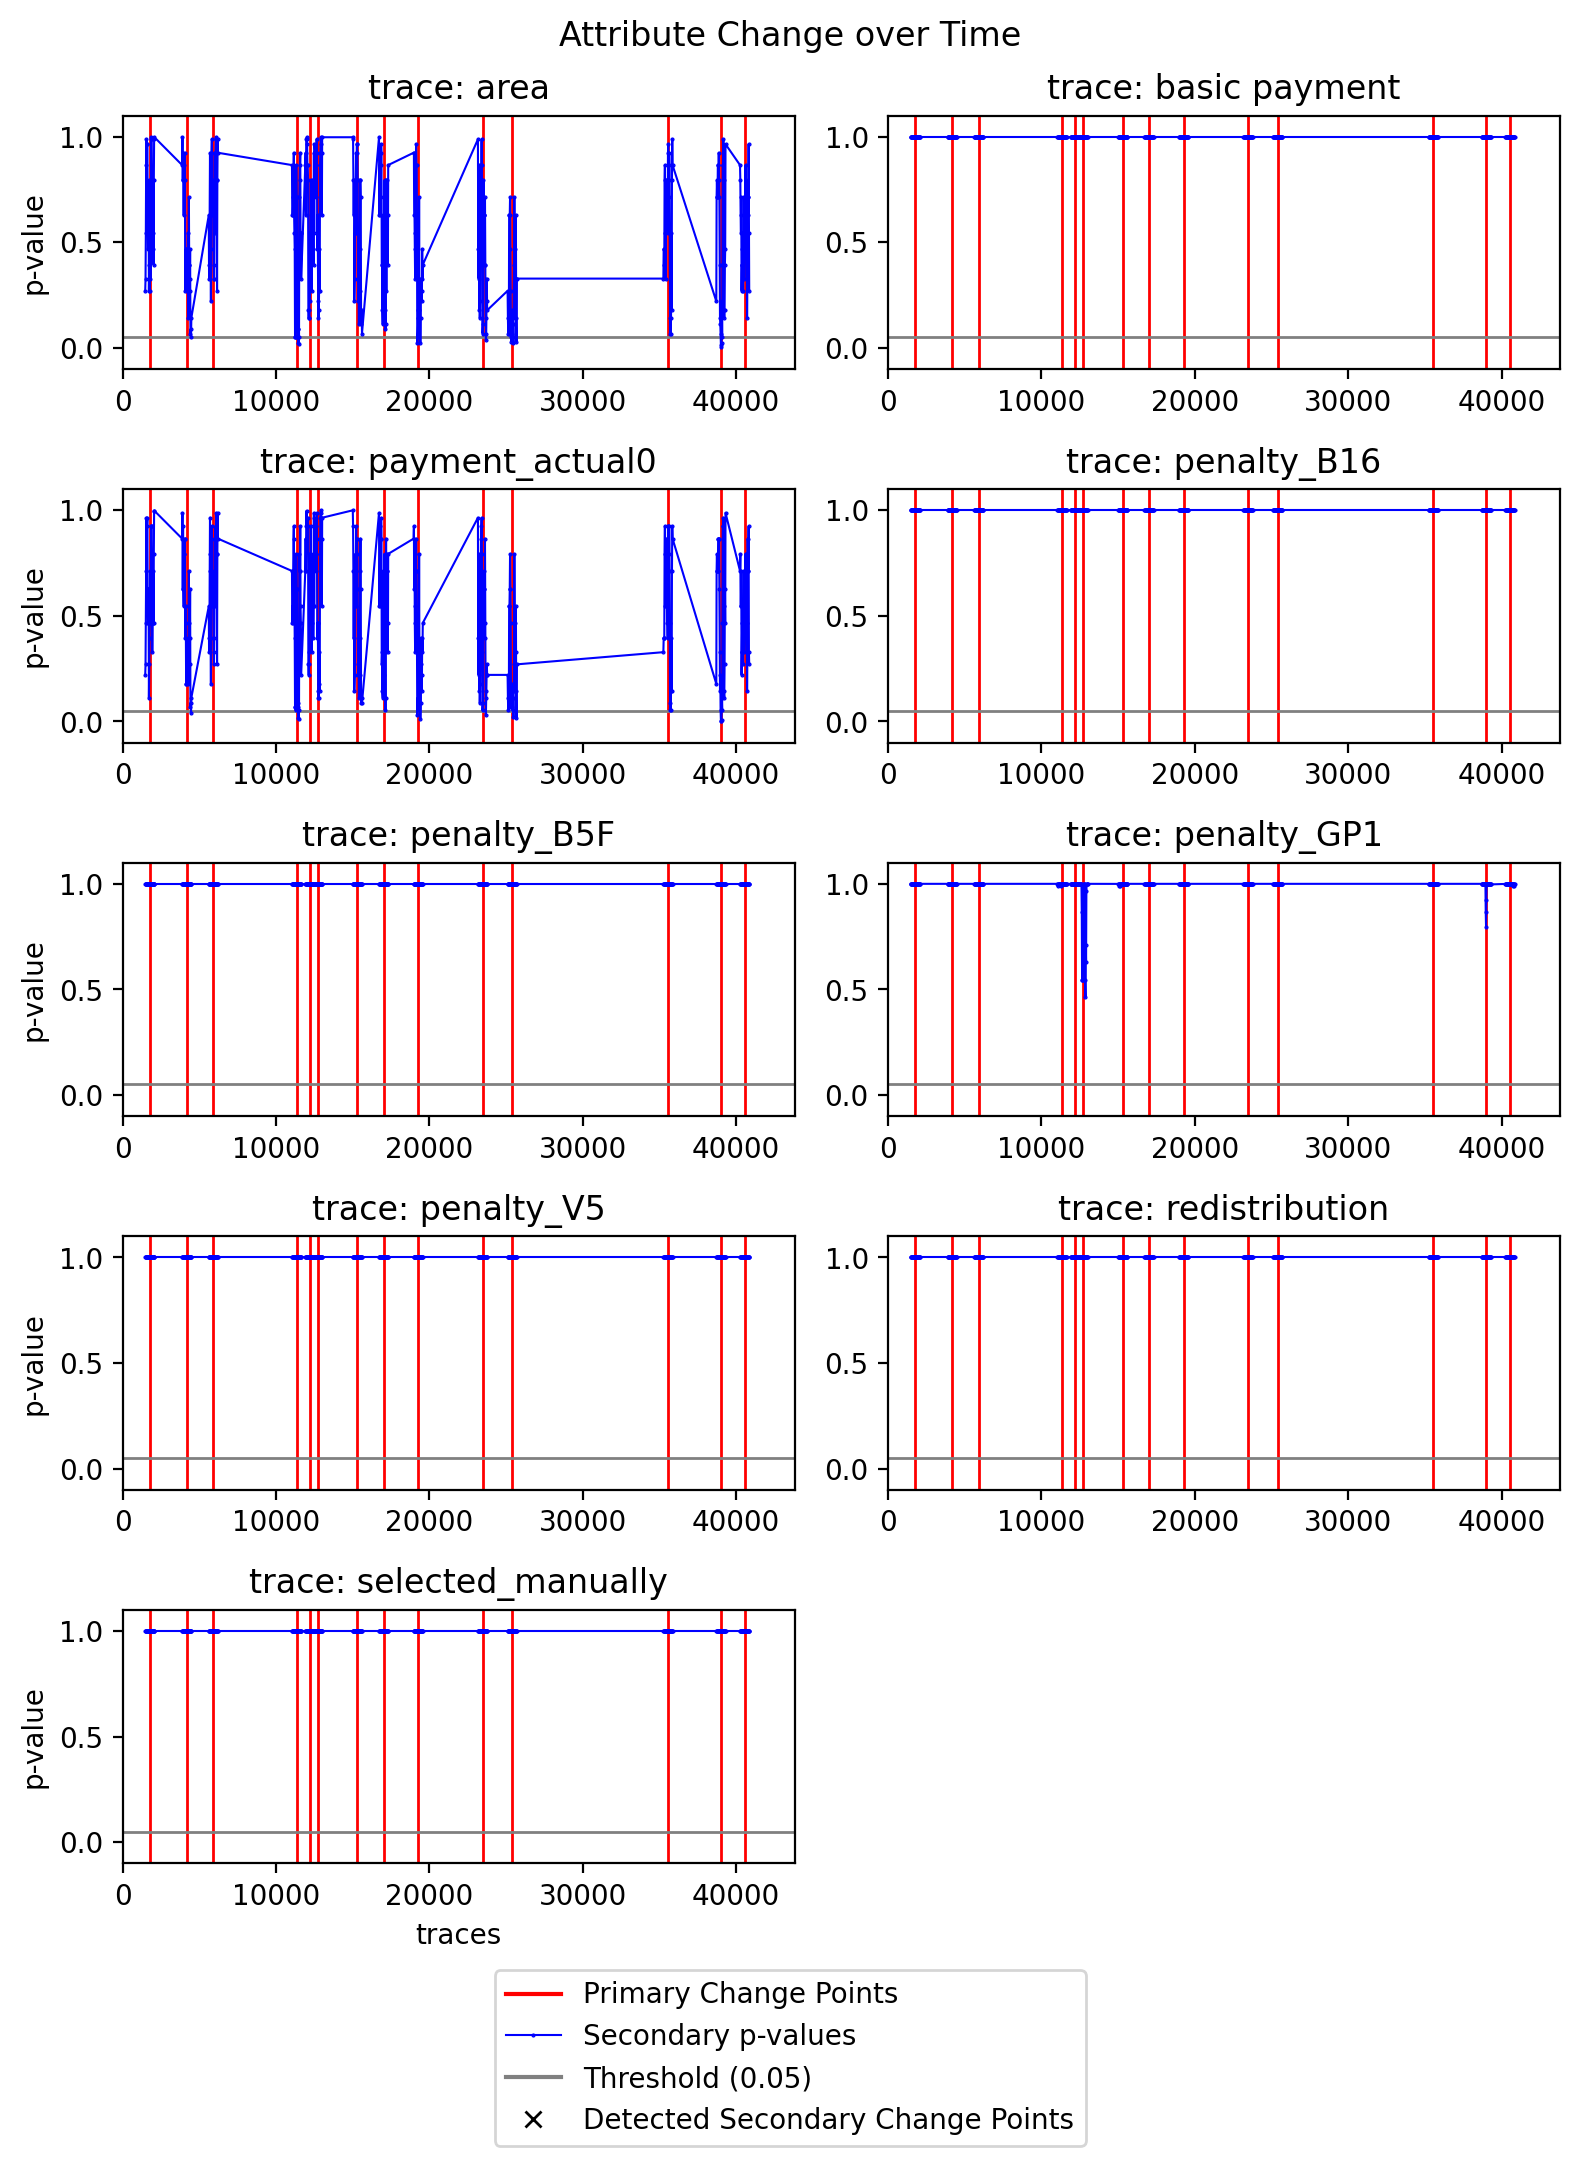

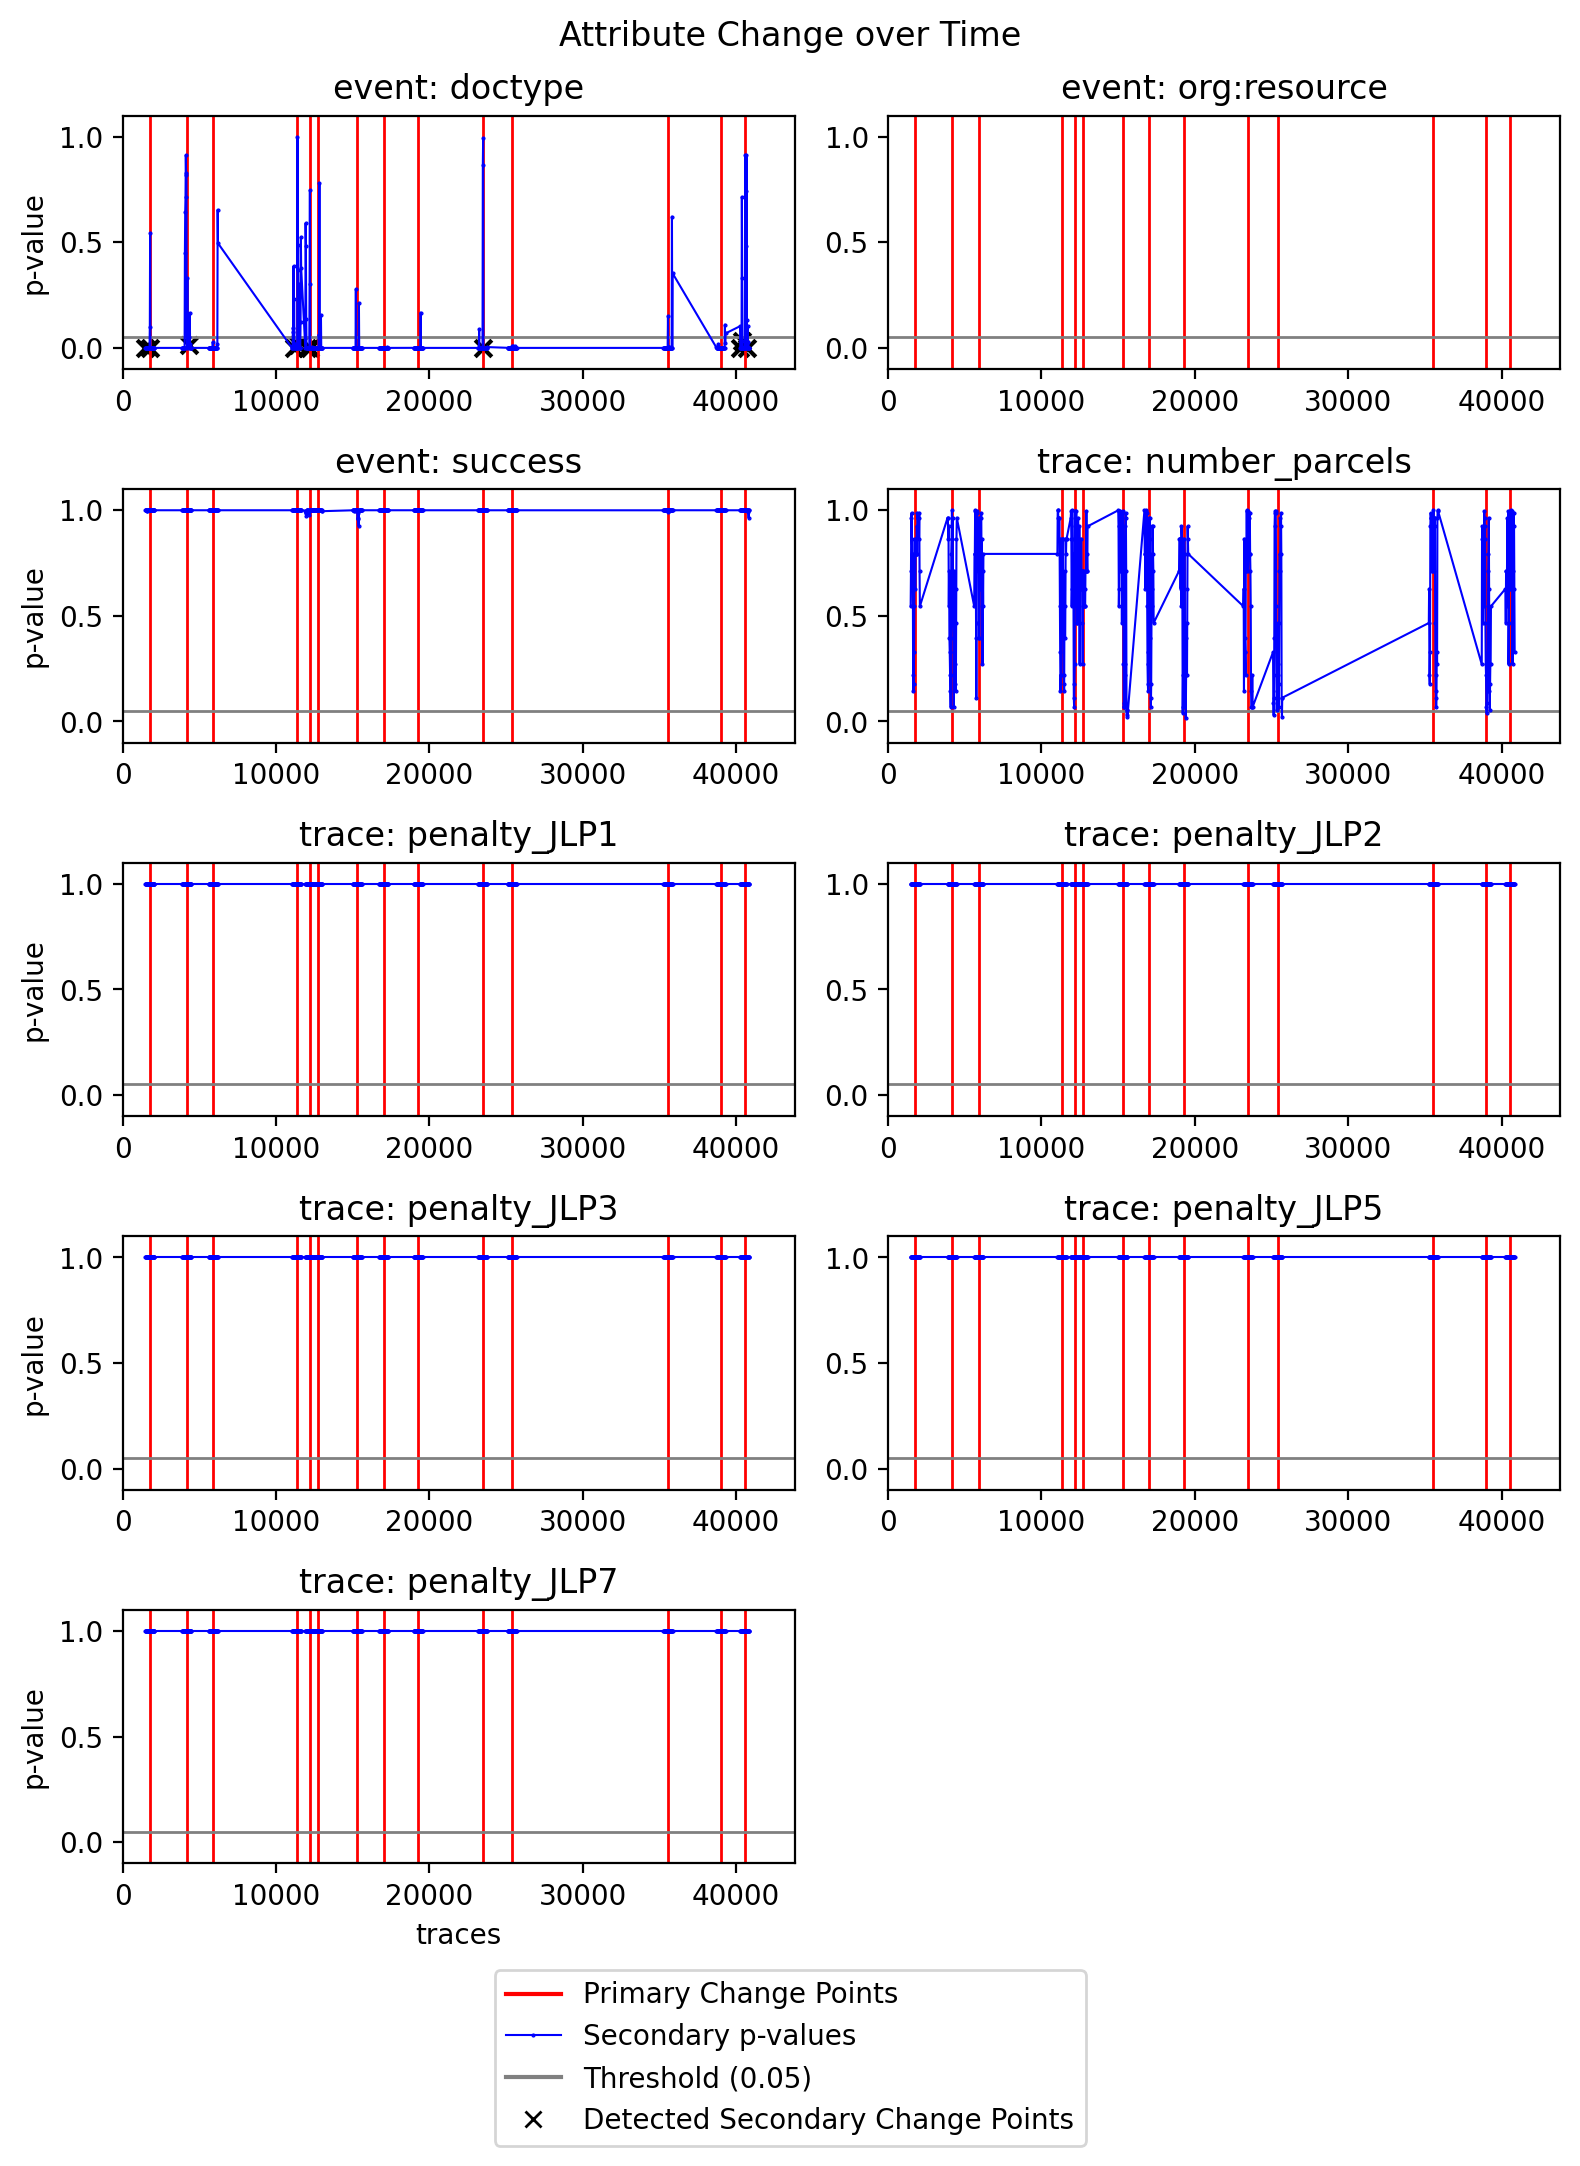

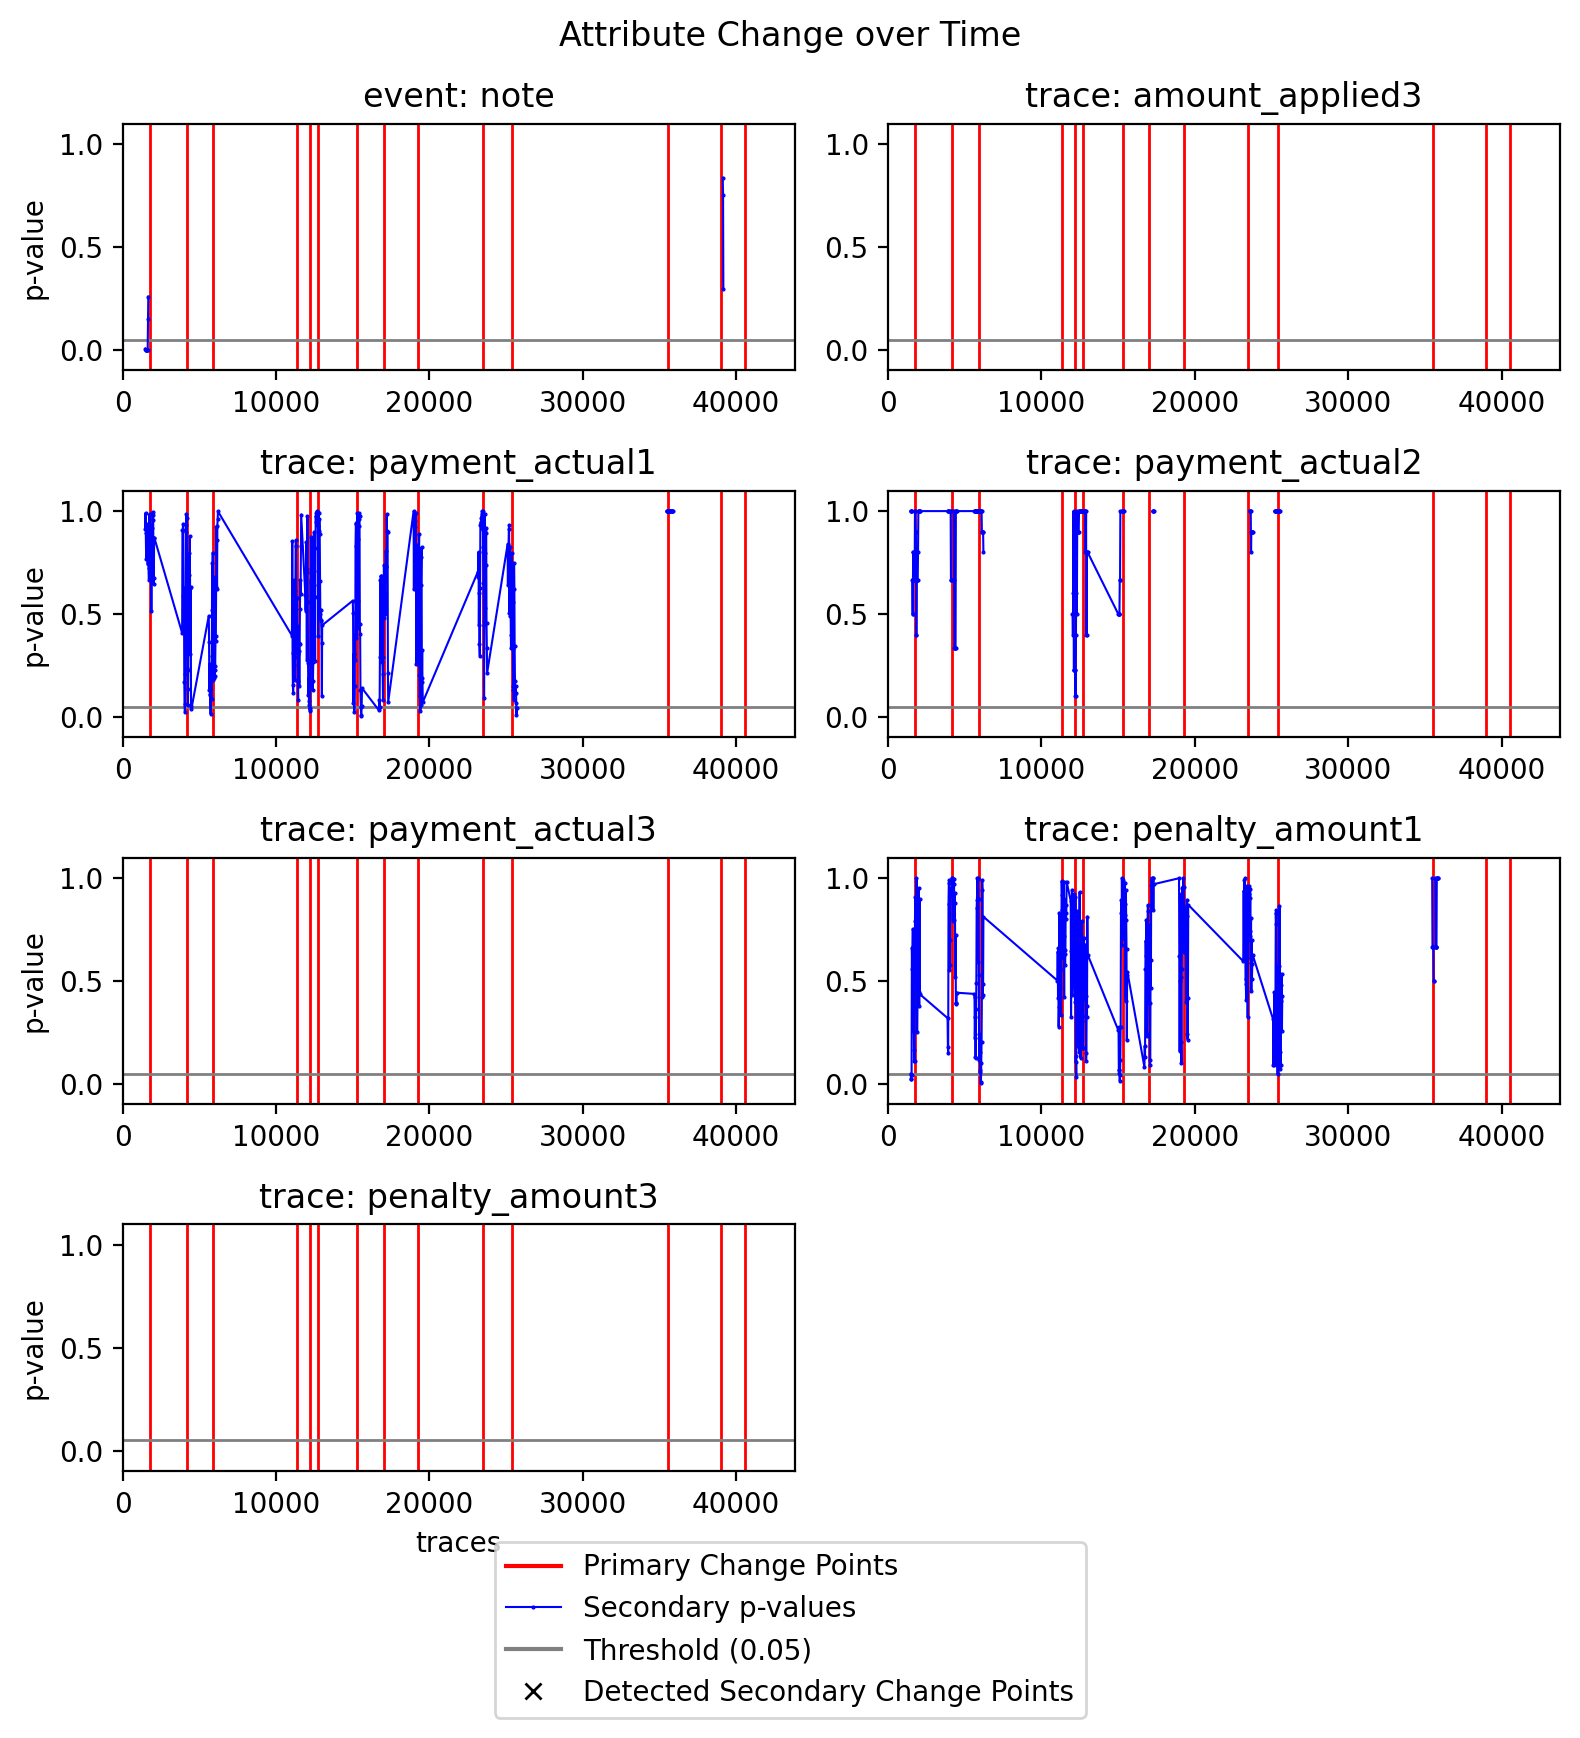

In [28]:
# plot all change graphs
secondary_result_keys = list(changes.secondary_dd_result_dictionary.keys())
for start, end in [(0, 9), (10, 19), (20, 29), (30, 39), (40, 49), (50, 59)]:
    selected_secondary_result_keys = secondary_result_keys[start:end]
    # filter for the selected keys
    selected_secondary_results = {key:value for key, value in changes.secondary_dd_result_dictionary.items() if key in selected_secondary_result_keys}

    # create a new change explanation object
    selected_changes = drift_explanation.DriftExplanationResult(changes.primary_dd_result, selected_secondary_results, None)
    selected_changes.plot(offset_legend=-0.09)

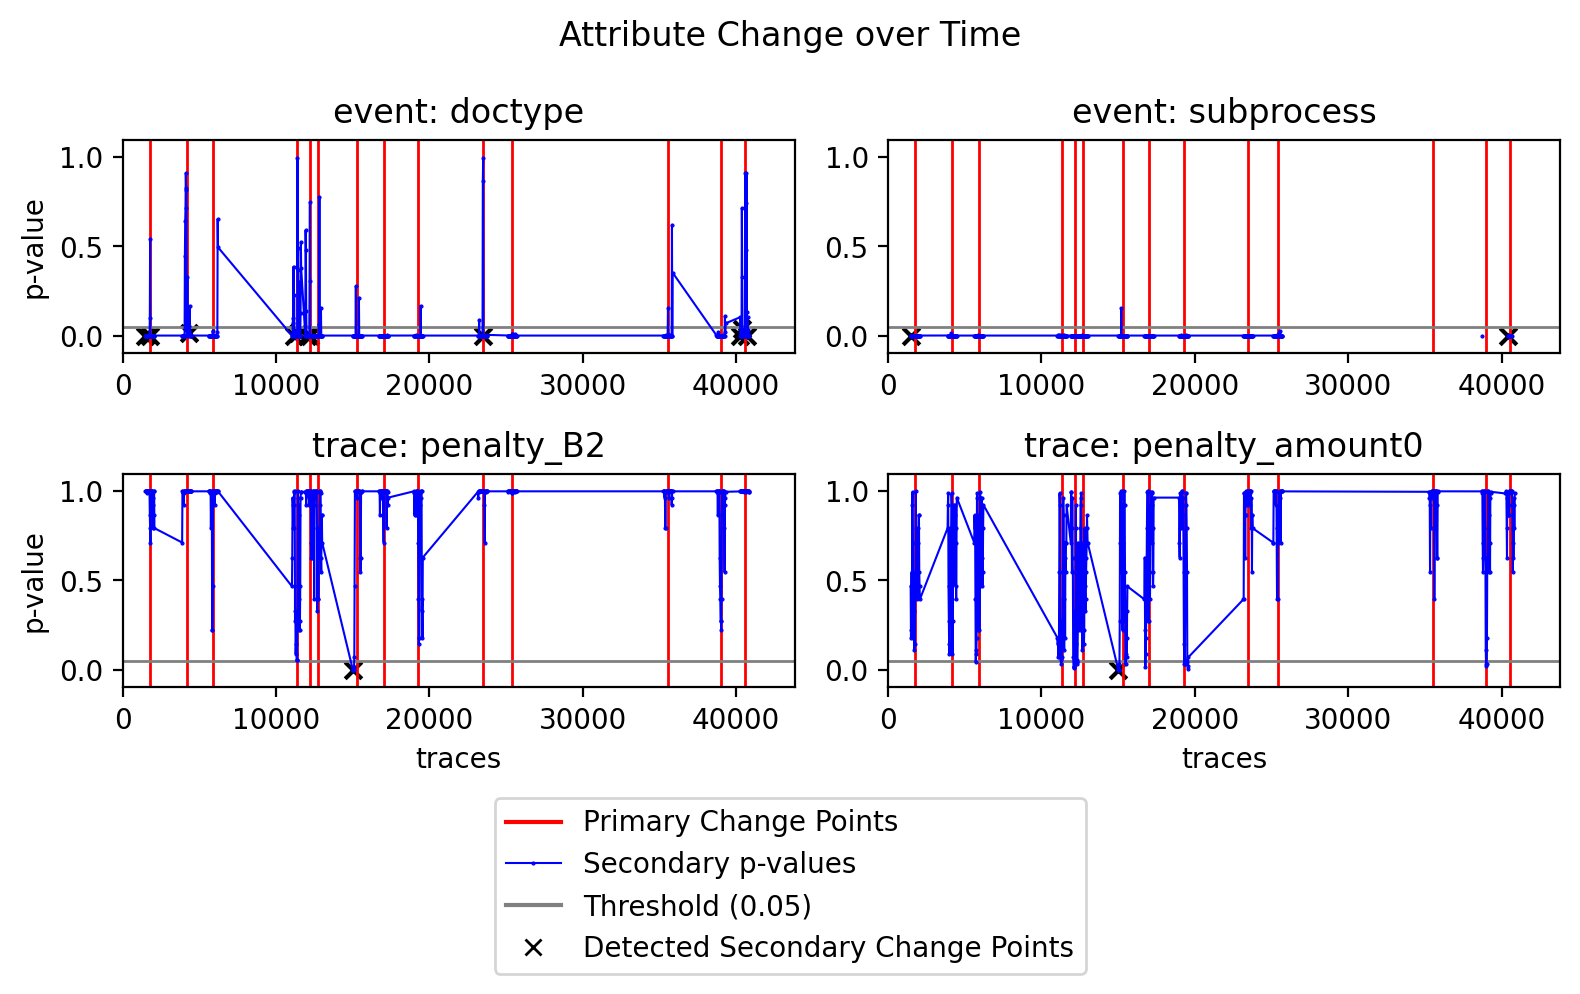

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [29]:
# due to the many attributes, the above graph is too big for gaining insights from it
# create a graph with only the p-value curves of the detectors which recorded secondary change points
attributes_with_changes = list(changes.to_table()['Detector'].unique())

# create a explanation result object with only these attributes

# get the secondary drift detection results for these attribute detectors
selected_secondary_dd_result_dictionary = {attribute: changes.secondary_dd_result_dictionary[attribute] for attribute in attributes_with_changes}

changes_selected = drift_explanation.DriftExplanationResult(changes.primary_dd_result, selected_secondary_dd_result_dictionary, None)
changes_selected.plot(offset_legend=-0.23)

## Analysis event attribute 'doctype'
Several secondary change points have been found for the attribute 'doctype'.

In [30]:
# show some example values
examples_event_attributes = helper.get_examples_of_event_attributes(event_log, 10, event_attributes)
examples_event_attributes['doctype']

0            Control summary
1        Payment application
2        Payment application
3        Reference alignment
4            Parcel document
5    Entitlement application
6        Payment application
7        Payment application
8        Reference alignment
9        Geo parcel document
Name: doctype, dtype: object

In [31]:
def plot(self, primary_change_points=None, threshold=None, secondary_change_points=None, start=None, end=None, ylabel='p-value', offset_legend = -0.87):
        plt.figure(dpi=200, figsize = (4,2))

        # get start and end of change series if desired
        selected_change_series = self.change_series
        if start is not None and end is not None:
            selected_change_series = selected_change_series.loc[start:end]
        elif start is not None and end is None:
            selected_change_series = selected_change_series.loc[start:]
        elif start is None and end is not None:
            selected_change_series = selected_change_series.loc[:end]

        plt.plot(selected_change_series, color='blue', 
                            marker=".", linewidth=0.75, markersize=1,
                            label=f"p-value")

        # plot the primary change points if some where defined
        if primary_change_points is not None:
            # plot the change points by a red line
            for pcp in primary_change_points:
                plt.axvline(x=pcp, color='red', linewidth=1)

        # plot the secondary change points if some where defined
        if secondary_change_points is not None:
            # plot the secondary change points with crosses
            x = secondary_change_points
            # check if there were secondary change points
            if x is not None:
                y = list(self.change_series.loc[secondary_change_points])
                plt.scatter(x=x, 
                    y=y,
                    marker='x',
                    color='black'
                )
        
        # plot the threshold as a grey line
        if threshold is not None:
            plt.axhline(y=threshold, color='grey', linewidth=1)

        plt.ylabel(ylabel)
        plt.xlabel('traces')
        plt.title(f'{self.name}')

        plt.ylim(-0.01, 1.1)
        plt.xlim(min(selected_change_series.index) - 10, max(selected_change_series.index) + 10)

        # create the legend
        legend_elements = []
        if primary_change_points is not None:
            legend_elements.append(lines.Line2D([0], [0], color='red', linestyle='solid', label='Primary Change Points'))
        
        legend_elements.append(lines.Line2D([0], [0], color='blue', marker=".", linewidth=0.75, markersize=1, label='Secondary Change Series'))

        if threshold is not None:
            legend_elements.append(lines.Line2D([0], [0], color='grey', linewidth=1, label=f'Threshold'))

        if secondary_change_points is not None:
            legend_elements.append(lines.Line2D([0], [0], color='black', marker='x', linestyle='None', label=f'Detected Secondary Change Points'))

        plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, offset_legend))

NameError: name 'lines' is not defined

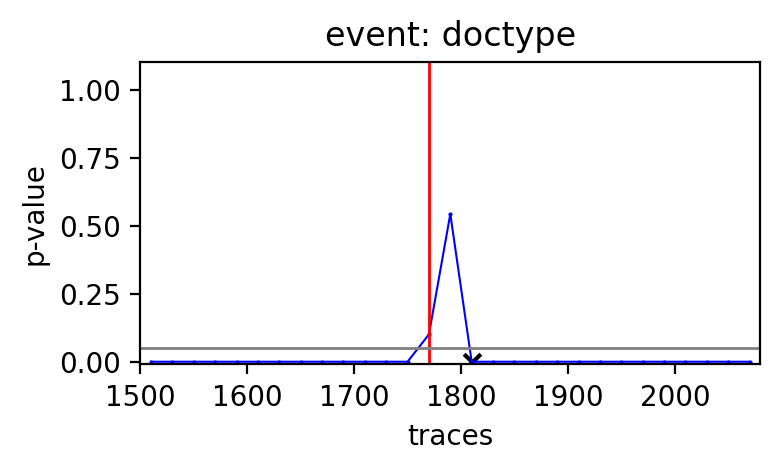

In [32]:
# Investigate the doctype value composition before and after a selected change point.
# One 'doctype' change point was recorded at trace 1810. Enlarge the p-value curve to 
# see whether there were steady states for this attribute before and after this trace.

doctype_detector_result = changes.secondary_dd_result_dictionary['event: doctype']

width = 300
center = 1810

# doctype_detector_result.plot(changes.primary_dd_result.change_points, 0.05, start=center-width, end=center+width, offset_legend=-0.45)

plot(doctype_detector_result, changes.primary_dd_result.change_points, secondary_change_points=doctype_detector_result.change_points, threshold=0.05, start=center-width, end=center+width, offset_legend=-1.06)

From the graph above it can be seen that 'doctype' was continuously changing but had values above the threshold for 

## Analysis event attribute 'subprocess'
The attribute continuously has values below the p-value line. It is surprising that not more change points have been registered. Like for the 'doctype' attribute, also for this attribute, first example values are shown. Second, a section of the p-value curve is magnified. 

In [ ]:
examples_event_attributes['subprocess']

0       Reported
1    Application
2    Application
3           Main
4    Application
5           Main
6    Application
7    Application
8    Application
9       Reported
Name: subprocess, dtype: object

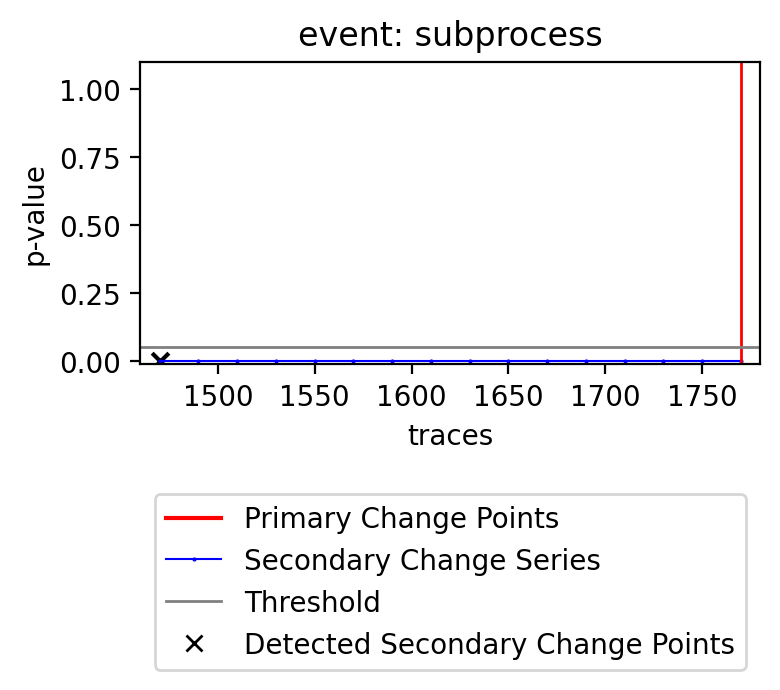

In [ ]:
# magnify the p-value curve around the first primary change point and then 
# also around the second where there was no recorded secondary change point.
subprocess_detector_result = changes.secondary_dd_result_dictionary['event: subprocess']

width = 300
center = 1470

# subprocess_detector_result.plot(changes.primary_dd_result.change_points, 0.05, start=center-width, end=center+width, offset_legend=-0.45)
plot(subprocess_detector_result, changes.primary_dd_result.change_points, secondary_change_points=subprocess_detector_result.change_points, threshold=0.05, start=center-width, end=center+width, offset_legend=-1.06)

In [ ]:
subprocess_detector_result.change_points

[40412, 1470]

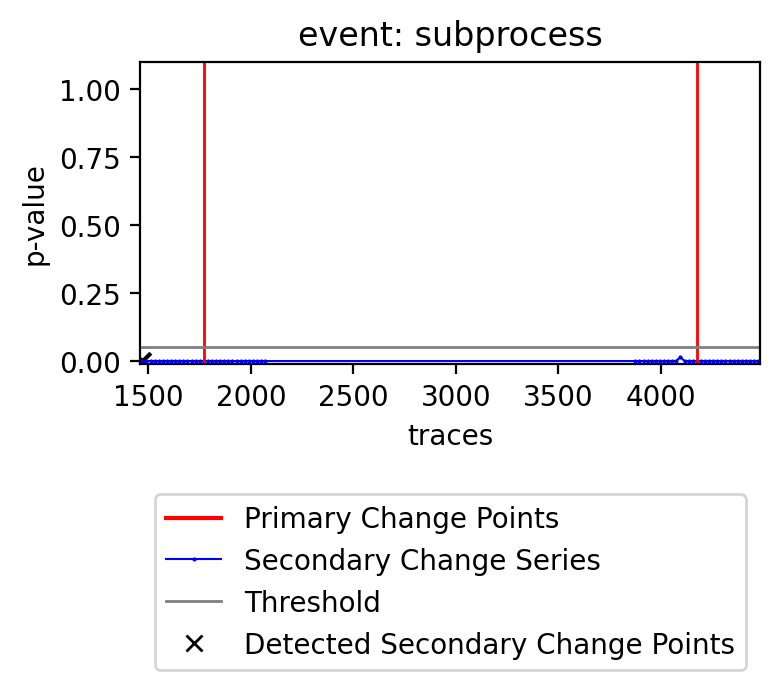

In [ ]:
plot(subprocess_detector_result, changes.primary_dd_result.change_points, secondary_change_points=subprocess_detector_result.change_points, threshold=0.05, start=0, end=4800, offset_legend=-1.06)

## Analysis trace attribute 'penalty_B2'

In [ ]:
helper.get_examples_of_trace_attributes(event_log, 20, trace_attributes)['penalty_B2']

0      True
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12     True
13     True
14    False
15     True
16     True
17    False
18    False
19    False
Name: penalty_B2, dtype: bool

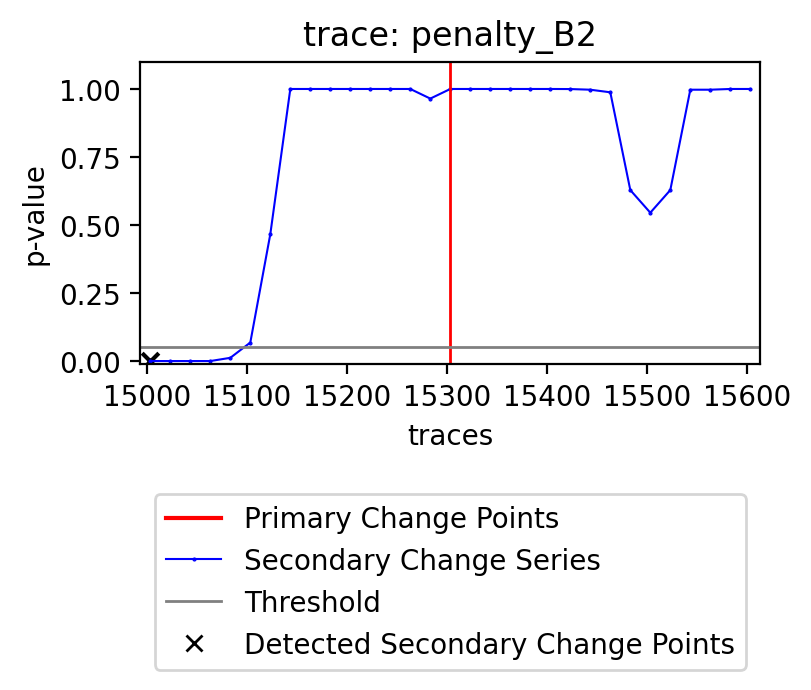

In [ ]:
penalty_b2_detector_result = changes.secondary_dd_result_dictionary['trace: penalty_B2']

width = 300
center = 15303
plot(penalty_b2_detector_result, changes.primary_dd_result.change_points, secondary_change_points=penalty_b2_detector_result.change_points, threshold=0.05, start=center-width, end=center+width, offset_legend=-1.06)

In [ ]:
# get the penalty_B2 drift detector
pb2_dd = None
for sdd in secondary_drift_detectors:
    if sdd.name == 'trace: penalty_B2':
        pb2_dd = sdd

# get teh event log between traces 14600 and 15200
trace_start = 14600
trace_end = 15200
# pb2_sub_event_log = EventLog(event_log[trace_start:trace_end+1], attributes=event_log.attributes, extensions=event_log.extensions, classifiers=event_log.classifiers,
                # omni_present=event_log.omni_present, properties=event_log.properties)

# pb2_changes = pb2_dd.get_changes(pb2_sub_event_log)
pb2_changes = pb2_dd.get_changes(event_log, around_change_points=[15000], max_distance=800)
pb2_changes

Results for Drift Detector trace: penalty_B2:
Change points: [14860]
Has a change series.

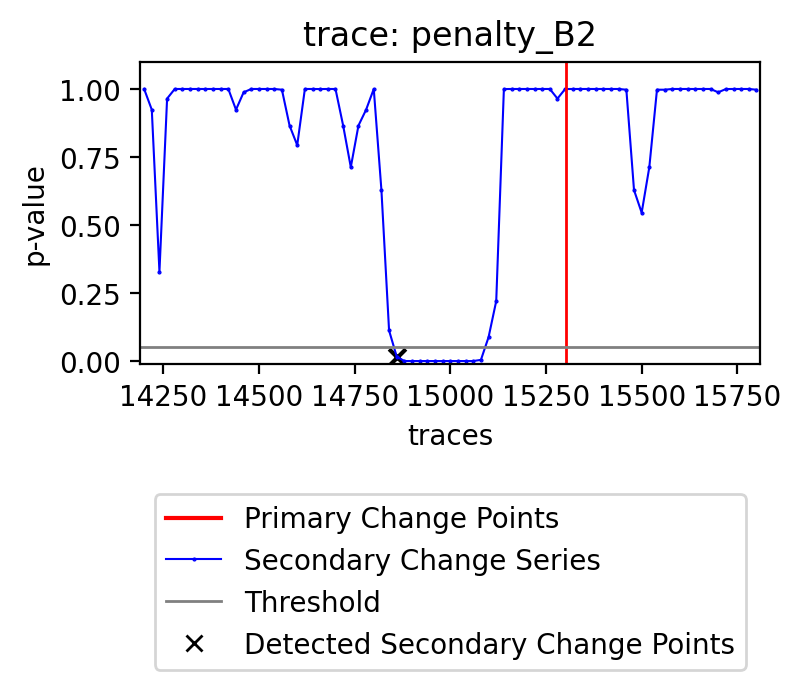

In [ ]:
plot(pb2_changes, changes.primary_dd_result.change_points, secondary_change_points=pb2_changes.change_points, threshold=0.05, offset_legend=-1.06)

The p-value curve of trace attribute 'penalty_B2' resembles the "expected curve" closely. Data before and after drop in p-value are observed.

Considering that the detection window size was 200, the following 100-trace windows where drawn.

Window 1:

- Start: 14750 - 2 * 200 - 99
- End: 14750 - 2 * 200

Window 2:

- Start: 15160 - 2 * 200 - 99
- End: 15160 - 2 * 200

In [ ]:
# get the data from the two windows before/after the steady state
window_1_start = 14750 - 2 * 200 - 99
window_1_end = 14750 - 2 * 200
window_2_start = 15160 - 2 * 200 - 99
window_2_end = 15160 - 2 * 200

# extract the attributes for each data window
# build an attribute feature extractor
fe = feature_extraction.AttributeFE('trace', 'penalty_B2')

# extract the attribute arrays
attribute_values_window_1_array = fe.extract(event_log[window_1_start:window_1_end+1])
attribute_values_window_2_array = fe.extract(event_log[window_2_start:window_2_end+1])

# construct into series with correct trace indeces
attribute_values_window_1 = pd.Series(attribute_values_window_1_array, index=range(window_1_start, window_1_end+1))
attribute_values_window_2 = pd.Series(attribute_values_window_2_array, index=range(window_2_start, window_2_end+1))

# replace None values with string 'None' for plotting purposes
attribute_values_window_1 = attribute_values_window_1.fillna('None')
attribute_values_window_2 = attribute_values_window_2.fillna('None')

# show unique values
value_counts_win_1 = attribute_values_window_1.value_counts()
value_counts_win_2 = attribute_values_window_2.value_counts()

print('Value Counts Window 1')
display(value_counts_win_1)
print('Value Counts Window 2')
display(value_counts_win_2)

# build a results dataframe
df = pd.DataFrame([value_counts_win_1, value_counts_win_2], index=['Before CP', 'After CP']).transpose()
# df.loc['Uitgebreid Ratio'] = df.loc['Uitgebreid'] / df.sum()
display(df)

# write to latex table
path = 'results/latex/bpic_2018_penalty_B2_before_after_cp.tex'
with open(path, 'w') as file:
    df.to_latex(file, float_format="%.2f")

Value Counts Window 1


True     57
False    43
dtype: int64

Value Counts Window 2


True     62
False    38
dtype: int64

,Before CP,After CP
True,57,62
False,43,38


C:\Users\Lennart\AppData\Local\Temp\ipykernel_12644\3940565539.py:40: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(file, float_format="%.2f")


## Analysis event attribute 'penalty_amount0'

In [ ]:
helper.get_examples_of_trace_attributes(event_log, 10, trace_attributes)['penalty_amount0']

0      0.00
1      0.00
2      0.00
3      0.00
4    666.04
5      0.00
6      0.00
7      0.00
8      0.00
9    353.25
Name: penalty_amount0, dtype: float64

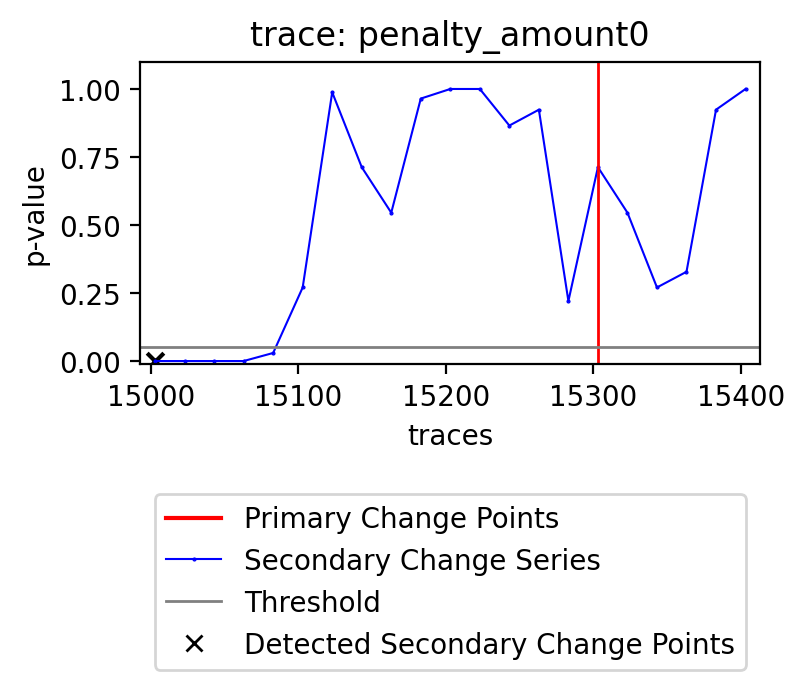

In [ ]:
penalty_amount0_detector_result = changes.secondary_dd_result_dictionary['trace: penalty_amount0']

width = 400
center = 15003
plot(penalty_amount0_detector_result, changes.primary_dd_result.change_points, secondary_change_points=penalty_amount0_detector_result.change_points, threshold=0.05, start=center-width, end=center+width, offset_legend=-1.06)

In [ ]:
# get the penalty_B2 drift detector
pa0_dd = None
for sdd in secondary_drift_detectors:
    if sdd.name == 'trace: penalty_amount0':
        pa0_dd = sdd

# get teh event log between traces 14600 and 15200
trace_start = 14600
trace_end = 15200
# pb2_sub_event_log = EventLog(event_log[trace_start:trace_end+1], attributes=event_log.attributes, extensions=event_log.extensions, classifiers=event_log.classifiers,
                # omni_present=event_log.omni_present, properties=event_log.properties)

pa0_changes = pa0_dd.get_changes(event_log, around_change_points=[15000], max_distance=800)
pa0_changes

Results for Drift Detector trace: penalty_amount0:
Change points: [14840]
Has a change series.

In [33]:
plot(pa0_changes, changes.primary_dd_result.change_points, secondary_change_points=pa0_changes.change_points, threshold=0.05, offset_legend=-1)

NameError: name 'pa0_changes' is not defined

C:\Users\Lennart\AppData\Local\Temp\ipykernel_22160\3265416101.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, max(max(attribute_values_window_1), max(attribute_values_window_2)))


Text(0, 0.5, 'penalty_amount0 [log]')

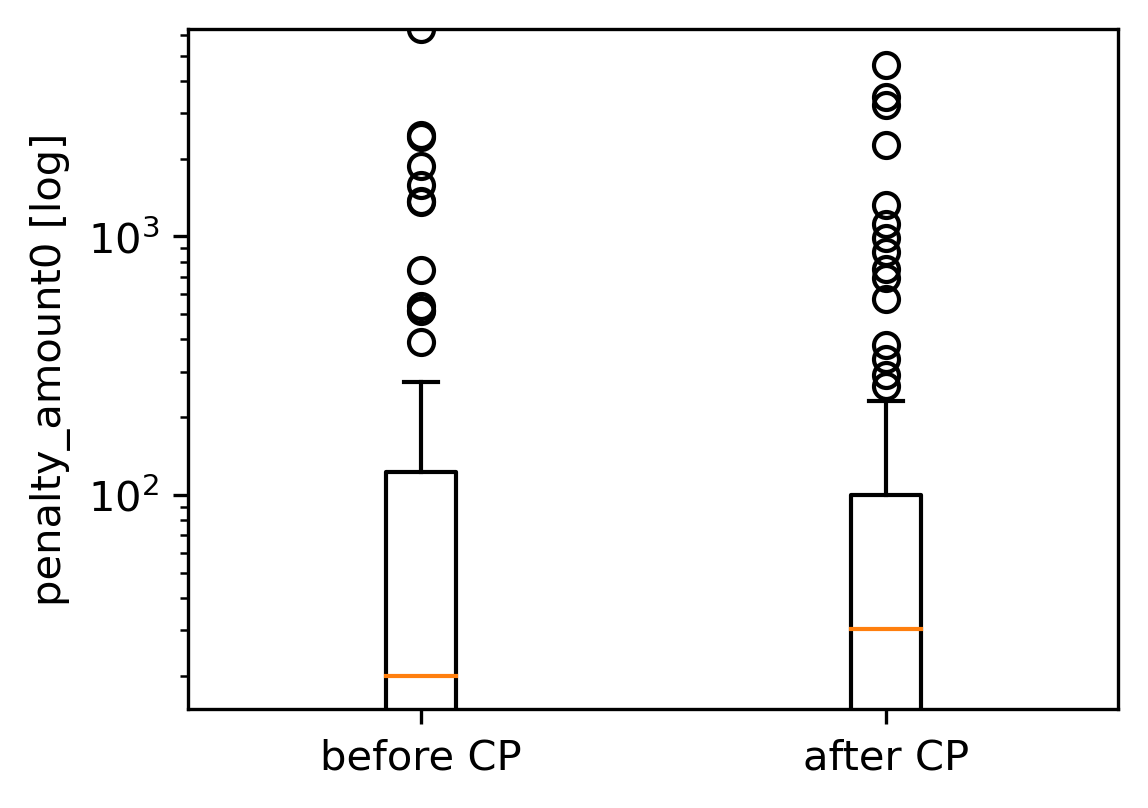

In [34]:
# get the data from the two windows before/after the steady state
window_1_start = 14750 - 2 * 200 - 99
window_1_end = 14750 - 2 * 200
window_2_start = 15120 - 2 * 200 - 99
window_2_end = 15120 - 2 * 200

# extract the attributes for each data window
# build an attribute feature extractor
fe = feature_extraction.AttributeFE('trace', 'penalty_amount0')

# extract the attribute arrays
attribute_values_window_1_array = fe.extract(event_log[window_1_start:window_1_end+1])
attribute_values_window_2_array = fe.extract(event_log[window_2_start:window_2_end+1])

# construct into series with correct trace indeces
attribute_values_window_1 = pd.Series(attribute_values_window_1_array, index=range(window_1_start, window_1_end+1))
attribute_values_window_2 = pd.Series(attribute_values_window_2_array, index=range(window_2_start, window_2_end+1))

# create boxplot 
plt.figure(figsize=(4, 3), dpi=300)
plt.boxplot ([attribute_values_window_1, attribute_values_window_2], labels=['before CP', 'after CP'])
plt.yscale('log')
plt.ylim(0, max(max(attribute_values_window_1), max(attribute_values_window_2)))
plt.ylabel('penalty_amount0 [log]')

In [35]:
# plot basic info on series
combined_df = pd.DataFrame([attribute_values_window_1, attribute_values_window_2], index=['before CP', 'after CP'])
combined_df = combined_df.transpose()
combined_df.describe()

,before CP,after CP
count,100.000000,100.000000
mean,239.517600,244.673400
std,766.148996,706.052168
min,0.000000,0.000000
25%,0.000000,0.000000
50%,19.900000,30.420000
75%,122.887500,99.820000
max,6323.310000,4592.960000


In [36]:
df = combined_df.describe().loc[['mean', '25%', '50%', '75%']]
display(df)

# write to latex table
path = 'results/latex/bpic_2018_penalty_amount0.tex'
with open(path, 'w') as file:
    df.to_latex(file, float_format="%.2f")

,before CP,after CP
mean,239.5176,244.6734
25%,0.0000,0.0000
50%,19.9000,30.4200
75%,122.8875,99.8200


C:\Users\Lennart\AppData\Local\Temp\ipykernel_22160\970212008.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(file, float_format="%.2f")


In [50]:
sorted_before = attribute_values_window_1.sort_values()
sorted_before = sorted_before.reset_index(drop=True)
sorted_after = attribute_values_window_2.sort_values()
sorted_after = sorted_after.reset_index(drop=True)

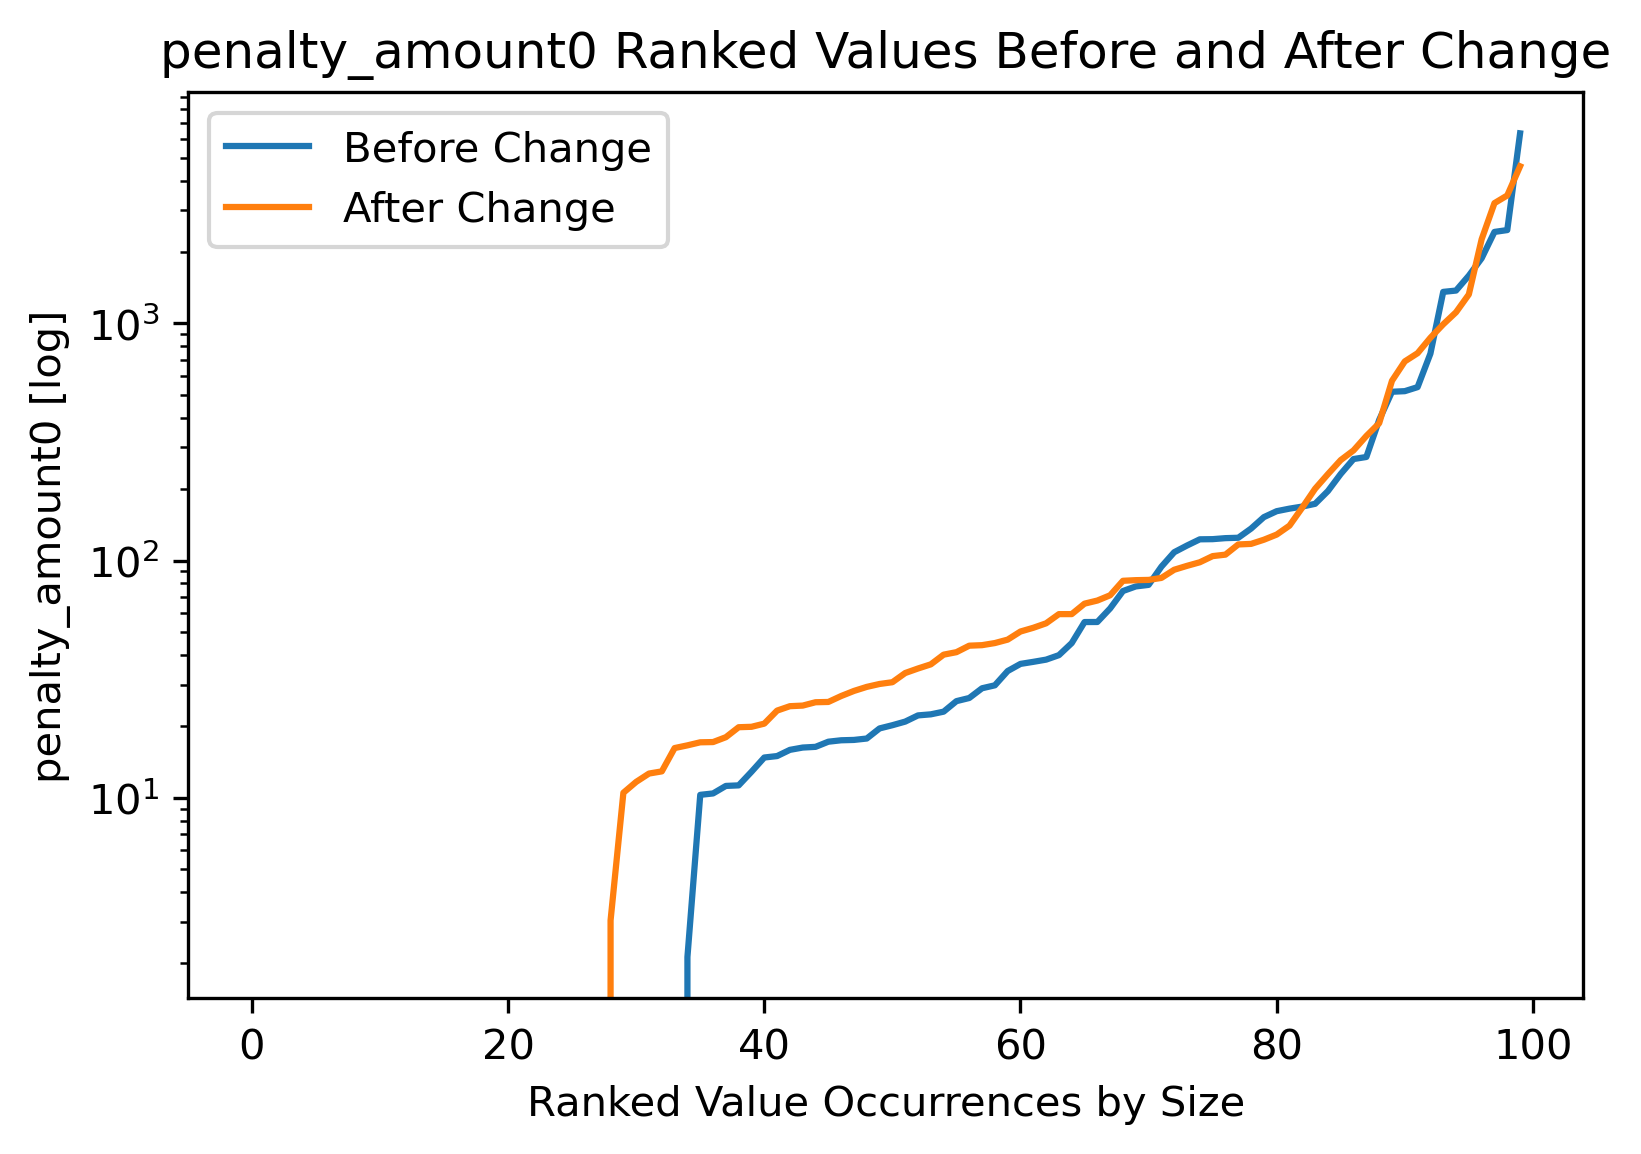

In [63]:
plt.figure(dpi=300)
sorted_before.plot(label='Before Change')
sorted_after.plot(label='After Change')

plt.xlabel('Ranked Value Occurrences by Size')
plt.ylabel('penalty_amount0 [log]')

plt.title('penalty_amount0 Ranked Values Before and After Change')

plt.yscale('log')

plt.legend()